In [2]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = ""



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from dcmnet.rdkit_utils import get_mol_from_id


# import pybel

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [3]:
mbis = Path("/pchem-data/meuwly/boittier/home/analysis/MBIS")
mbisdata = mbis.glob("*pkl")

In [4]:
failed = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-fails.csv")
failed = list(failed["0"])

In [5]:
data = {_.stem: pd.read_pickle(_) for _ in mbisdata}

In [6]:
data = {k:v for k,v in data.items() if k not in failed}

In [7]:
list(data.keys())[:10]

['dsgdb9nsd_129885',
 'dsgdb9nsd_130481',
 'dsgdb9nsd_128167',
 'dsgdb9nsd_130149',
 'dsgdb9nsd_130966',
 'dsgdb9nsd_131296',
 'dsgdb9nsd_133202',
 'dsgdb9nsd_132354',
 'dsgdb9nsd_131306',
 'dsgdb9nsd_128954']

In [8]:
keys = [k for k in list(data.keys()) if k not in failed]
# keys

In [9]:
data["dsgdb9nsd_128954"]

{'mono': array([-6.89695072e-03, -6.82634603e-03, -6.08240419e-03, ...,
         1.09206025e-09,  1.09206025e-09,  1.09206025e-09]),
 'dipo': array([-7.29053686e-03, -7.40661290e-03, -6.89535156e-03, ...,
         1.17315690e-09,  1.17315690e-09,  1.17315690e-09]),
 'quad': array([-7.27839981e-03, -7.35752800e-03, -6.79966470e-03, ...,
         1.17315828e-09,  1.17315828e-09,  1.17315828e-09]),
 'esp': array([-0.00725657, -0.00726441, -0.00661951, ...,  0.        ,
         0.        ,  0.        ]),
 'closest_atom_type': array([7, 7, 7, ..., 1, 1, 1]),
 'closest_atom': array([ 0,  0,  0, ..., 12, 12, 12]),
 'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'rmse_mono': Array(1.5774539, dtype=float32),
 'rmse_dipo': Array(1.3724021, dtype=float32),
 'rmse_quad': Array(1.2095424, dtype=float32),
 'rmse_mono_masked': Array(0.8994933, dtype=float32),
 'rmse_dipo_masked': Array(0.5674174, dtype=float32),
 'rmse_quad_masked': Array(0.43492696, dtype=float32),
 'D_mono': Arra

In [10]:
chemical_groups = {
    "HGA1": "Aliphatic proton, CH",
    "HGA2": "Aliphatic proton, CH2",
    "HGA3": "Aliphatic proton, CH3",
    "HGP1": "Polar hydrogen",
    "HGP4": "Polar hydrogen, neutral conjugated -NH2 group (found in nucleic acid bases)",
    "HGPAM1": "Polar hydrogen, neutral dimethylamine group",
    "HGPAM2": "Polar hydrogen, neutral methylamine group",
    "HGR51": "Nonpolar hydrogen, neutral 5-membered planar ring carbon, Lennard-Jones potential based on benzene",
    "HGR52": "Aldehyde hydrogen, formamide hydrogen (RCOH); nonpolar hydrogen, neutral 5-membered planar ring carbon adjacent to heteroatom or positive charge",
    "HGR61": "Aromatic hydrogen",
    "HGR62": "Nonpolar hydrogen, neutral 6-membered planar ring carbon adjacent to heteroatom",
    "CG1T1": "Alkyne carbon (R-C≡C)",
    "CG1T2": "Alkyne carbon (H-C≡C)",
    "CG1N1": "Carbon in cyano group (C≡N)",
    "CG2O1": "Carbonyl carbon in amides",
    "CG2O4": "Carbonyl carbon in aldehydes",
    "CG2R51": "5-membered ring carbon in histidine (CG, CD2(0)) or tryptophan",
    "CG2R52": "5-membered ring carbon double-bonded to nitrogen (e.g., pyrrole, pyrazole)",
    "CG2R53": "5-membered ring carbon double-bonded to nitrogen and adjacent to another heteroatom (e.g., purine C8, histidine CE1)",
    "CG2R61": "6-membered aromatic carbon",
    "CG2R62": "6-membered aromatic carbon for protonated pyridine and rings with carbonyl groups",
    "CG2R63": "6-membered aromatic amide carbon (nucleic acids) and other carbonyl-containing rings",
    "CG2R64": "6-membered aromatic amidine/guanidine carbon (between 2-3 nitrogens, double-bonded to one of them)",
    "CG2R66": "6-membered aromatic carbon bound to fluorine",
    "CG2RC0": "6/5-membered ring bridging carbon (e.g., guanine C4, C5, tryptophan)",
    "CG2R71": "7-membered aromatic carbon (e.g., azulene)",
    "NG1T1": "Nitrogen in cyano group",
    "NG2D1": "Nitrogen in neutral imine/Schiff's base (C=N-R, acyclic amidine, guanidine)",
    "NG2S3": "External amine ring nitrogen (planar/aniline, phosphoramidate)",
    "NG2R50": "Double-bonded nitrogen in neutral 5-membered planar ring (e.g., purine N7)",
    "NG2R51": "Single-bonded nitrogen in neutral 5-membered planar ring (e.g., histidine, tryptophan pyrrole)",
    "NG2R60": "Double-bonded nitrogen in neutral 6-membered planar ring (e.g., pyridine)",
    "NG2R61": "Single-bonded nitrogen in neutral 6-membered planar ring (glycosyl linkage)",
    "NG2R62": "Double-bonded nitrogen in 6-membered planar ring with heteroatoms (e.g., pyrimidine)",
    "NG311": "Neutral dimethylamine nitrogen",
    "NG321": "Neutral methylamine nitrogen",
    "OG2D1": "Carbonyl oxygen in amides, esters, carboxylic acids, aldehydes, urea",
    "OG2D4": "6-membered aromatic carbonyl oxygen (nucleic acids)",
    "OG2R50": "Oxygen in furan ring (FURA)",
    "OG3R60": "Oxygen in 6-membered cyclic enol ether or ester",
    "OG301": "Ether oxygen (-O-)",
    "OG311": "Hydroxyl oxygen",
    "FGA3": "Aliphatic fluorine, trifluoro group",
    "FGR1": "Aromatic fluorine"
}

In [11]:
charge_comparison = pd.read_csv("charge-comparison.csv")

charge_comparison[charge_comparison["qm9_id"] == "dsgdb9nsd_129885"]

Unnamed: 0            qm9_id atom_id  idx element    mbis_q  cgenff_q
40436       40436  dsgdb9nsd_129885   NG321    0       N -0.871048    -0.724
40437       40437  dsgdb9nsd_129885  CG2R51    1       C  0.490477     0.251
40438       40438  dsgdb9nsd_129885  CG2R51    2       C -0.376906    -0.424
40439       40439  dsgdb9nsd_129885  NG2R51    3       N  0.166459     0.361
40440       40440  dsgdb9nsd_129885  NG2R50    4       N -0.164323    -0.354
40441       40441  dsgdb9nsd_129885  NG2R50    5       N -0.358507    -0.390
40442       40442  dsgdb9nsd_129885  CG3C31    6       C -0.009349     0.134
40443       40443  dsgdb9nsd_129885  CG3C31    7       C -0.347882    -0.180
40444       40444  dsgdb9nsd_129885  CG3C31    8       C -0.346065    -0.180
40445       40445  dsgdb9nsd_129885  HGPAM2    9       H  0.391503     0.371
40446       40446  dsgdb9nsd_129885  HGPAM2   10       H  0.375202     0.371
40447       40447  dsgdb9nsd_129885   HGR52   11       H  0.196931     0.314
40448       40448  dsgdb9nsd_129885    HGA1   12       H  0.165280     0.090
40449       40449  dsgdb9nsd_129885    HGA2   13       H  0.172234     0.090
40450       40450  dsgdb9nsd_129885    HGA2   14       H  0.171151     0.090
40451       40451  dsgdb9nsd_129885    HGA2   15       H  0.172824     0.090
40452       40452  dsgdb9nsd_129885    HGA2   16       H  0.172100     0.090

In [12]:
from dcmnet.esp_atom import esp_rmse_atoms, esp_rmse_cgenff, esp_rmse_atoms_model, esp_rmse_cgenff_model


In [60]:
analysis_dirs = list(Path("/pchem-data/meuwly/boittier/home/analysis/").glob("202410*dcm*"))
# mbisdata = mbis.glob("*pkl")

In [61]:
for i, _ in enumerate(analysis_dirs):
    print(i, _)

0 /pchem-data/meuwly/boittier/home/analysis/20241002-180908dcm-4-w-10000
1 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-3-w-10000
2 /pchem-data/meuwly/boittier/home/analysis/20241002-175338dcm-2-w-10000
3 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-2-w-10000
4 /pchem-data/meuwly/boittier/home/analysis/20241002-180732dcm-3-w-10000
5 /pchem-data/meuwly/boittier/home/analysis/20241002-180916dcm-2-w-10000
6 /pchem-data/meuwly/boittier/home/analysis/20241002-180941dcm-2-w-10000
7 /pchem-data/meuwly/boittier/home/analysis/20241002-180943dcm-4-w-10000
8 /pchem-data/meuwly/boittier/home/analysis/20241002-180930dcm-4-w-10000
9 /pchem-data/meuwly/boittier/home/analysis/20241002-180931dcm-3-w-10000
10 /pchem-data/meuwly/boittier/home/analysis/20241002-182242dcm-4-w-10000
11 /pchem-data/meuwly/boittier/home/analysis/20241002-182301dcm-3-w-10000


In [ ]:
# 2 10 11

In [84]:
pickles = [list(_.glob("*pkl")) for _ in analysis_dirs]
model_data = {_.stem: pd.read_pickle(_) for _ in pickles[2]}

In [85]:
model_cgenff_esp_dfs = []
for k in tqdm(keys[::]):
    try:
        _ = pd.DataFrame(esp_rmse_cgenff_model(model_data[k], 
                                               data[k]["esp"],
                                               data[k]["closest_atom"],
                                               charge_comparison[charge_comparison["qm9_id"] == k])).T
        _ = _.rename(columns={ 0: "Z", 1:"mono", 2: "npoints"})
        _["id"] = k
        model_cgenff_esp_dfs.append(_)
    except Exception as e:
        print(e)
        pass


100%|██████████████████████████████████████████████████████████████████████████████████████████| 6506/6506 [05:37<00:00, 19.30it/s]


In [86]:
model_cgenff_esp_df = pd.concat(model_cgenff_esp_dfs)
model_cgenff_esp_df = model_cgenff_esp_df[model_cgenff_esp_df["npoints"] >= 1]
model_mean_cgenff = model_cgenff_esp_df[["Z", "mono", "npoints"]].groupby("Z").mean()

In [87]:
model_mean_cgenff_top = model_mean_cgenff[model_mean_cgenff["npoints"] > 50]
model_mean_cgenff_top["description"] = [chemical_groups[x] if x in chemical_groups.keys() else "" 
                                        for x in model_mean_cgenff_top.index]
df = model_mean_cgenff_top[["mono", "description"]].sort_values(["Z"])

# Define a function to apply bold formatting to values < 0.51
def highlight_below_threshold(val):
    if val < 0.49:
        return f"\\textbf{{{val:.2f}}}"  # LaTeX bold for values less than 0.51
    else:
        return f"{val:.2f}"

# Apply the function to the 'mono' column
# styled_df = df.style.applymap(highlight_below_threshold, subset=['mono', 'dipo', 'quad'])
# styled_df.to_latex()
df['mono'] = df['mono'].apply(highlight_below_threshold)
# df['dipo'] = df['dipo'].apply(highlight_below_threshold)
# df['quad'] = df['quad'].apply(highlight_below_threshold)

# Convert the DataFrame to LaTeX
latex_table = df.to_latex(index=True, escape=False)  # escape=False to allow LaTeX commands

# Display the LaTeX code
print(latex_table)

\begin{tabular}{lll}
\toprule
 & mono & description \\
Z &  &  \\
\midrule
CG1N1 & 1.30 & Carbon in cyano group (C≡N) \\
CG1T1 & 1.45 & Alkyne carbon (R-C≡C) \\
CG1T2 & 0.80 & Alkyne carbon (H-C≡C) \\
CG2R71 & 2.32 & 7-membered aromatic carbon (e.g., azulene) \\
FGA3 & \textbf{0.19} & Aliphatic fluorine, trifluoro group \\
FGR1 & \textbf{0.40} & Aromatic fluorine \\
HGA1 & \textbf{0.34} & Aliphatic proton, CH \\
HGA2 & \textbf{0.27} & Aliphatic proton, CH2 \\
HGA3 & \textbf{0.23} & Aliphatic proton, CH3 \\
HGP1 & \textbf{0.36} & Polar hydrogen \\
HGP4 & \textbf{0.31} & Polar hydrogen, neutral conjugated -NH2 group (found in nucleic acid bases) \\
HGPAM1 & \textbf{0.44} & Polar hydrogen, neutral dimethylamine group \\
HGPAM2 & \textbf{0.27} & Polar hydrogen, neutral methylamine group \\
HGR51 & \textbf{0.38} & Nonpolar hydrogen, neutral 5-membered planar ring carbon, Lennard-Jones potential based on benzene \\
HGR52 & \textbf{0.36} & Aldehyde hydrogen, formamide hydrogen (RCOH); nonpola

In [71]:
cgenff_esp_dfs = []
for k in tqdm(keys[:]):
    try:
        _ = pd.DataFrame(esp_rmse_cgenff(data[k], charge_comparison[charge_comparison["qm9_id"] == k])).T
        _ = _.rename(columns={ 0: "Z", 1:"mono", 2:"dipo", 3:"quad", 4:"mav", 5: "npoints"})
        _["d%"] = 100*(_["dipo"] - _["mono"] )/_["mono"]
        _["q%"] = 100*(_["quad"] - _["mono"] )/_["mono"]
        _["d"] = _["dipo"] - _["mono"]
        _["q"] = _["quad"] - _["mono"] 
        _["id"] = k
        cgenff_esp_dfs.append(_)
    except Exception as e:
        print(e)
        pass


100%|██████████████████████████████████████████████████████████████████████████████████████████| 6506/6506 [02:19<00:00, 46.70it/s]


In [ ]:
cgenff_esp_df = pd.concat(cgenff_esp_dfs)
cgenff_esp_df = cgenff_esp_df[cgenff_esp_df["npoints"] >= 1]
mean_cgenff = cgenff_esp_df[["Z", "mono", "dipo", "quad", "d%", "q%", "d", "q", "npoints"]].groupby("Z").mean()

In [517]:
mean_cgenff_top = mean_cgenff[mean_cgenff["npoints"] > 50]
mean_cgenff_top["description"] = [chemical_groups[x] if x in chemical_groups.keys() else "" for x in mean_cgenff_top.index]
df = mean_cgenff_top[["mono", "dipo", "quad", "description"]].sort_values(["Z"])

# Define a function to apply bold formatting to values < 0.51
def highlight_below_threshold(val):
    if val < 0.49:
        return f"\\textbf{{{val:.2f}}}"  # LaTeX bold for values less than 0.51
    else:
        return f"{val:.2f}"

# Apply the function to the 'mono' column
# styled_df = df.style.applymap(highlight_below_threshold, subset=['mono', 'dipo', 'quad'])
# styled_df.to_latex()
df['mono'] = df['mono'].apply(highlight_below_threshold)
df['dipo'] = df['dipo'].apply(highlight_below_threshold)
df['quad'] = df['quad'].apply(highlight_below_threshold)

# Convert the DataFrame to LaTeX
latex_table = df.to_latex(index=True, escape=False)  # escape=False to allow LaTeX commands

# Display the LaTeX code
print(latex_table)

\begin{tabular}{lllll}
\toprule
 & mono & dipo & quad & description \\
Z &  &  &  &  \\
\midrule
CG1N1 & 1.34 & 0.71 & \textbf{0.48} & Carbon in cyano group (C≡N) \\
CG1T1 & 1.42 & 0.61 & \textbf{0.42} & Alkyne carbon (R-C≡C) \\
CG1T2 & 0.84 & \textbf{0.38} & \textbf{0.25} & Alkyne carbon (H-C≡C) \\
CG2R71 & 2.59 & 0.64 & \textbf{0.42} & 7-membered aromatic carbon (e.g., azulene) \\
FGA3 & \textbf{0.20} & \textbf{0.06} & \textbf{0.04} & Aliphatic fluorine, trifluoro group \\
FGR1 & 0.50 & \textbf{0.16} & \textbf{0.10} & Aromatic fluorine \\
HGA1 & 0.51 & \textbf{0.12} & \textbf{0.08} & Aliphatic proton, CH \\
HGA2 & \textbf{0.40} & \textbf{0.11} & \textbf{0.07} & Aliphatic proton, CH2 \\
HGA3 & \textbf{0.31} & \textbf{0.09} & \textbf{0.06} & Aliphatic proton, CH3 \\
HGP1 & \textbf{0.49} & \textbf{0.12} & \textbf{0.08} & Polar hydrogen \\
HGP4 & \textbf{0.43} & \textbf{0.09} & \textbf{0.06} & Polar hydrogen, neutral conjugated -NH2 group (found in nucleic acid bases) \\
HGPAM1 & \textbf

In [432]:
top_ats = cgenff_esp_df.Z.unique()

In [433]:
cgenff = """MASS   256 HGA1     1.00800  ! alphatic proton, CH
MASS   257 HGA2     1.00800  ! alphatic proton, CH2
MASS   258 HGA3     1.00800  ! alphatic proton, CH3
MASS   259 HGA4     1.00800  ! alkene proton; RHC=
MASS   260 HGA5     1.00800  ! alkene proton; H2C=CR
MASS   261 HGA6     1.00800  ! aliphatic H on fluorinated C, monofluoro
MASS   262 HGA7     1.00800  ! aliphatic H on fluorinated C, difluoro
MASS   263 HGAAM0   1.00800  ! aliphatic H, NEUTRAL trimethylamine (#)
MASS   264 HGAAM1   1.00800  ! aliphatic H, NEUTRAL dimethylamine (#)
MASS   265 HGAAM2   1.00800  ! aliphatic H, NEUTRAL methylamine (#)
MASS   266 HGP1     1.00800  ! polar H
MASS   267 HGP2     1.00800  ! polar H, +ve charge
MASS   268 HGP3     1.00800  ! polar H, thiol
MASS   269 HGP4     1.00800  ! polar H, neutral conjugated -NH2 group (NA bases)
MASS   270 HGP5     1.00800  ! polar H on quarternary ammonium salt (choline)
MASS   271 HGPAM1   1.00800  ! polar H, NEUTRAL dimethylamine (#)
MASS   272 HGPAM2   1.00800  ! polar H, NEUTRAL methylamine (#)
MASS   273 HGPAM3   1.00800  ! polar H, NEUTRAL ammonia (#)
MASS   274 HGR51    1.00800  ! nonpolar H, neutral 5-mem planar ring C, LJ based on benzene
MASS   275 HGR52    1.00800  ! Aldehyde H, formamide H (RCOH); nonpolar H, neutral 5-mem planar ring C adjacent to heteroatom or + charge
MASS   276 HGR53    1.00800  ! nonpolar H, +ve charge HIS he1(+1)
MASS   277 HGR61    1.00800  ! aromatic H
MASS   278 HGR62    1.00800  ! nonpolar H, neutral 6-mem planar ring C adjacent to heteroatom
MASS   279 HGR63    1.00800  ! nonpolar H, NAD+ nicotineamide all ring CH hydrogens
MASS   280 HGR71    1.00800  ! nonpolar H, neutral 7-mem arom ring, AZUL, azulene, kevo
MASS   281 CG1T1   12.01100  ! alkyn R-C#C
MASS   283 CG1N1   12.01100  ! C for cyano group
MASS   284 CG2D1   12.01100  ! alkene; RHC= ; imine C
MASS   285 CG2D2   12.01100  ! alkene; H2C=
MASS   286 CG2D1O  12.01100  ! double bond carbon adjacent to heteroatom. In conjugated systems, the atom to which it is double bonded must be CG2DC1.
MASS   287 CG2D2O  12.01100  ! double bond carbon adjacent to heteroatom. In conjugated systems, the atom to which it is double bonded must be CG2DC2.
MASS   288 CG2DC1  12.01100  ! conjugated alkenes, R2C=CR2
MASS   289 CG2DC2  12.01100  ! conjugated alkenes, R2C=CR2
MASS   290 CG2DC3  12.01100  ! conjugated alkenes, H2C=
MASS   291 CG2N1   12.01100  ! conjugated C in guanidine/guanidinium
MASS   292 CG2N2   12.01100  ! conjugated C in amidinium cation
MASS   293 CG2O1   12.01100  ! carbonyl C: amides
MASS   294 CG2O2   12.01100  ! carbonyl C: esters, [neutral] carboxylic acids
MASS   295 CG2O3   12.01100  ! carbonyl C: [negative] carboxylates
MASS   296 CG2O4   12.01100  ! carbonyl C: aldehydes
MASS   297 CG2O5   12.01100  ! carbonyl C: ketones
MASS   298 CG2O6   12.01100  ! carbonyl C: urea, carbonate
MASS   299 CG2O7   12.01100  ! CO2 carbon
MASS   300 CG2R51  12.01100  ! 5-mem ring, his CG, CD2(0), trp
MASS   301 CG2R52  12.01100  ! 5-mem ring, double bound to N, PYRZ, pyrazole
MASS   302 CG2R53  12.01100  ! 5-mem ring, double bound to N and adjacent to another heteroatom, purine C8, his CE1 (0,+1), 2PDO, kevo
MASS   304 CG2R61  12.01100  ! 6-mem aromatic C
MASS   305 CG2R62  12.01100  ! 6-mem aromatic C for protonated pyridine (NIC) and rings containing carbonyls (see CG2R63) (NA)
MASS   306 CG2R63  12.01100  ! 6-mem aromatic amide carbon (NA) (and other 6-mem aromatic carbonyls?)
MASS   307 CG2R64  12.01100  ! 6-mem aromatic amidine and guanidine carbon (between 2 or 3 Ns and double-bound to one of them), NA, PYRM
MASS   308 CG2R66  12.01100  ! 6-mem aromatic carbon bound to F
MASS   309 CG2R67  12.01100  ! 6-mem aromatic carbon of biphenyl
MASS   310 CG2RC0  12.01100  ! 6/5-mem ring bridging C, guanine C4,C5, trp
MASS   311 CG2R71  12.01100  ! 7-mem ring arom C, AZUL, azulene, kevo
MASS   312 CG2RC7  12.01100  ! sp2 ring connection with single bond(!), AZUL, azulene, kevo
MASS   313 CG301   12.01100  ! aliphatic C, no hydrogens, neopentane
MASS   314 CG302   12.01100  ! aliphatic C, no hydrogens, trifluoromethyl
MASS   315 CG311   12.01100  ! aliphatic C with 1 H, CH
MASS   316 CG312   12.01100  ! aliphatic C with 1 H, difluoromethyl
MASS   317 CG314   12.01100  ! aliphatic C with 1 H, adjacent to positive N (PROT NTER) (+)
MASS   318 CG321   12.01100  ! aliphatic C for CH2
MASS   319 CG322   12.01100  ! aliphatic C for CH2, monofluoromethyl
MASS   320 CG323   12.01100  ! aliphatic C for CH2, thiolate carbon
MASS   321 CG324   12.01100  ! aliphatic C for CH2, adjacent to positive N (piperidine) (+)
MASS   322 CG331   12.01100  ! aliphatic C for methyl group (-CH3)
MASS   323 CG334   12.01100  ! aliphatic C for methyl group (-CH3), adjacent to positive N (PROT NTER) (+)
MASS   324 CG3AM0  12.01100  ! aliphatic C for CH3, NEUTRAL trimethylamine methyl carbon (#)
MASS   325 CG3AM1  12.01100  ! aliphatic C for CH3, NEUTRAL dimethylamine methyl carbon (#)
MASS   326 CG3AM2  12.01100  ! aliphatic C for CH3, NEUTRAL methylamine methyl carbon (#)
MASS   327 CG3C31  12.01100  ! cyclopropyl carbon
MASS   328 CG3C41  12.01100  ! cyclobutyl carbon
MASS   329 CG3C50  12.01100  ! 5-mem ring aliphatic quaternary C (cholesterol, bile acids)
MASS   330 CG3C51  12.01100  ! 5-mem ring aliphatic CH  (proline CA, furanoses)
MASS   331 CG3C52  12.01100  ! 5-mem ring aliphatic CH2 (proline CB/CG/CD, THF, deoxyribose)
MASS   332 CG3C53  12.01100  ! 5-mem ring aliphatic CH  adjacent to positive N (proline.H+ CA) (+)
MASS   333 CG3C54  12.01100  ! 5-mem ring aliphatic CH2 adjacent to positive N (proline.H+ CD) (+)
MASS   334 CG3RC1  12.01100  ! bridgehead in bicyclic systems containing at least one 5-membered or smaller ring
MASS   335 NG1T1   14.00700  ! N for cyano group
!MASS   336 NG1D1   14.00700  ! terminal N in azides, lsk
MASS   337 NG2D1   14.00700  ! N for neutral imine/Schiff's base (C=N-R, acyclic amidine, gunaidine)
MASS   338 NG2S0   14.00700  ! N,N-disubstituted amide, proline N (CO=NRR')
MASS   339 NG2S1   14.00700  ! peptide nitrogen (CO=NHR)
MASS   340 NG2S2   14.00700  ! terminal amide nitrogen (CO=NH2)
MASS   341 NG2S3   14.00700  ! external amine ring nitrogen (planar/aniline), phosphoramidate
!MASS   342 NG2S4   14.00700  ! neutral hydroxamic acid
MASS   343 NG2O1   14.00700  ! NITB, nitrobenzene
MASS   344 NG2P1   14.00700  ! N for protonated imine/Schiff's base (C=N(+)H-R, acyclic amidinium, guanidinium)
MASS   345 NG2R43  14.00700  ! amide in 4-memebered ring (planar), AZDO, lsk
MASS   346 NG2R50  14.00700  ! double bound neutral 5-mem planar ring, purine N7
MASS   347 NG2R51  14.00700  ! single bound neutral 5-mem planar (all atom types sp2) ring, his, trp pyrrole (fused)
MASS   348 NG2R52  14.00700  ! protonated schiff base, amidinium, guanidinium in 5-membered ring, HIS, 2HPP, kevo
MASS   349 NG2R53  14.00700  ! amide in 5-memebered NON-SP2 ring (slightly pyramidized), 2PDO, kevo
!MASS   350 NG2R57  14.00700  ! 5-mem ring, bipyrrole
MASS   351 NG2R60  14.00700  ! double bound neutral 6-mem planar ring, pyr1, pyzn
MASS   352 NG2R61  14.00700  ! single bound neutral 6-mem planar ring imino nitrogen; glycosyl linkage
MASS   353 NG2R62  14.00700  ! double bound 6-mem planar ring with heteroatoms in o or m, pyrd, pyrm
MASS   354 NG2RC0  14.00700  ! 6/5-mem ring bridging N, indolizine, INDZ, kevo
MASS   355 NG301   14.00700  ! neutral trimethylamine nitrogen
MASS   356 NG311   14.00700  ! neutral dimethylamine nitrogen
MASS   357 NG321   14.00700  ! neutral methylamine nitrogen
MASS   358 NG331   14.00700  ! neutral ammonia nitrogen
MASS   359 NG3C51  14.00700  ! secondary sp3 amine in 5-membered ring
MASS   360 NG3N1   14.00700  ! N in hydrazine, HDZN
MASS   361 NG3P0   14.00700  ! quarternary N+, choline
MASS   362 NG3P1   14.00700  ! tertiary NH+ (PIP)
MASS   363 NG3P2   14.00700  ! secondary NH2+ (proline)
MASS   364 NG3P3   14.00700  ! primary NH3+, phosphatidylethanolamine
MASS   365 OG2D1   15.99940  ! carbonyl O: amides, esters, [neutral] carboxylic acids, aldehydes, uera
MASS   366 OG2D2   15.99940  ! carbonyl O: negative groups: carboxylates, carbonate
MASS   367 OG2D3   15.99940  ! carbonyl O: ketones
MASS   368 OG2D4   15.99940  ! 6-mem aromatic carbonyl oxygen (nucleic bases)
MASS   369 OG2D5   15.99940  ! CO2 oxygen
MASS   370 OG2N1   15.99940  ! NITB, nitrobenzene
MASS   371 OG2P1   15.99940  ! =O in phosphate or sulfate
MASS   372 OG2R50  15.99940  ! FURA, furan
MASS   373 OG3R60  15.99940  ! O in 6-mem cyclic enol ether (PY01, PY02) or ester
MASS   374 OG301   15.99940  ! ether -O- 
MASS   375 OG302   15.99940  ! ester -O-
MASS   376 OG303   15.99940  ! phosphate/sulfate ester oxygen
MASS   377 OG304   15.99940  ! linkage oxygen in pyrophosphate/pyrosulphate
MASS   378 OG311   15.99940  ! hydroxyl oxygen
MASS   379 OG312   15.99940  ! ionized alcohol oxygen
MASS   380 OG3C31  15.99940  ! epoxide oxygen, 1EOX, 1BOX, sc
MASS   381 OG3C51  15.99940  ! 5-mem furanose ring oxygen (ether)
MASS   382 OG3C61  15.99940  ! DIOX, dioxane, ether in 6-membered ring 
MASS   383 SG2D1   32.06000  ! thiocarbonyl S
MASS   384 SG2R50  32.06000  ! THIP, thiophene
MASS   385 SG311   32.06000  ! sulphur, SH, -S-
MASS   386 SG301   32.06000  ! sulfur C-S-S-C type
MASS   387 SG302   32.06000  ! thiolate sulfur (-1)
MASS   388 SG3O1   32.06000  ! sulfate -1 sulfur
MASS   389 SG3O2   32.06000  ! neutral sulfone/sulfonamide sulfur
MASS   390 SG3O3   32.06000  ! neutral sulfoxide sulfur
MASS   391 CLGA1   35.45300  ! CLET, DCLE, chloroethane, 1,1-dichloroethane
MASS   392 CLGA3   35.45300  ! TCLE, 1,1,1-trichloroethane
MASS   393 CLGR1   35.45300  ! CHLB, chlorobenzene
MASS   394 BRGA1   79.90400  ! BRET, bromoethane
MASS   395 BRGA2   79.90400  ! DBRE, 1,1-dibromoethane
MASS   396 BRGA3   79.90400  ! TBRE, 1,1,1-dibromoethane
MASS   397 BRGR1   79.90400  ! BROB, bromobenzene
MASS   398 IGR1   126.90447  ! IODB, iodobenzene
MASS   399 FGA1    18.99800  ! aliphatic fluorine, monofluoro
MASS   400 FGA2    18.99800  ! aliphatic fluorine, difluoro
MASS   401 FGA3    18.99800  ! aliphatic fluorine, trifluoro
MASS   402 FGP1    18.99800  ! anionic F, for ALF4 AlF4-
MASS   403 FGR1    18.99800  ! aromatic flourine
MASS   404 PG0     30.97380  ! neutral phosphate
MASS   405 PG1     30.97380  ! phosphate -1
MASS   406 PG2     30.97380  ! phosphate -2
MASS   407 ALG1    26.98154  ! Aluminum, for ALF4, AlF4-
MASS   408 CG25C1  12.01100  ! same as CG2DC1 but in 5-membered ring with exocyclic double bond
MASS   409 CG25C2  12.01100  ! same as CG2DC2 but in 5-membered ring with exocyclic double bond
MASS   410 CG251O  12.01100  ! same as CG2D1O but in 5-membered ring with exocyclic double bond
MASS   411 CG252O  12.01100  ! same as CG2D2O but in 5-membered ring with exocyclic double bond"""

In [434]:
for _ in cgenff.split("\n"):
    s = _.split()
    c = _.split("!")[-1]
    if s[2] in top_ats:
        print(s[2], c)
    

HGA1  alphatic proton, CH
HGA2  alphatic proton, CH2
HGA3  alphatic proton, CH3
HGP1  polar H
HGP4  polar H, neutral conjugated -NH2 group (NA bases)
HGPAM1  polar H, NEUTRAL dimethylamine (#)
HGPAM2  polar H, NEUTRAL methylamine (#)
HGR51  nonpolar H, neutral 5-mem planar ring C, LJ based on benzene
HGR52  Aldehyde H, formamide H (RCOH); nonpolar H, neutral 5-mem planar ring C adjacent to heteroatom or + charge
HGR61  aromatic H
HGR62  nonpolar H, neutral 6-mem planar ring C adjacent to heteroatom
CG1T1  alkyn R-C#C
CG1N1  C for cyano group
CG2O1  carbonyl C: amides
CG2O4  carbonyl C: aldehydes
CG2R51  5-mem ring, his CG, CD2(0), trp
CG2R52  5-mem ring, double bound to N, PYRZ, pyrazole
CG2R53  5-mem ring, double bound to N and adjacent to another heteroatom, purine C8, his CE1 (0,+1), 2PDO, kevo
CG2R61  6-mem aromatic C
CG2R62  6-mem aromatic C for protonated pyridine (NIC) and rings containing carbonyls (see CG2R63) (NA)
CG2R63  6-mem aromatic amide carbon (NA) (and other 6-mem arom

In [112]:
atom_esp_dfs = []
for k in tqdm(keys):
    _ = pd.DataFrame(esp_rmse_atoms(data[k])).T
    _ = _.rename(columns={ 0: "Z", 1:"mono", 2:"dipo", 3:"quad", 4:"mav", 5: "npoints"})
    _["d%"] = 100*(_["dipo"] - _["mono"] )/_["mono"]
    _["q%"] = 100*(_["quad"] - _["mono"] )/_["mono"]
    _["d"] = _["dipo"] - _["mono"]
    _["q"] = _["quad"] - _["mono"] 
    _["id"] = k
    atom_esp_dfs.append(_)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 6506/6506 [00:14<00:00, 454.34it/s]


In [113]:
# esp_rmse_atoms(data["dsgdb9nsd_133101"])

In [114]:
atom_esp_df = pd.concat(atom_esp_dfs)
atom_esp_df = atom_esp_df[atom_esp_df["npoints"] >= 0]
atom_esp_df[atom_esp_df["Z"] == 6]

Z      mono      dipo      quad       mav  npoints          d%  \
1   6.0  2.945019  1.324658  1.075977  6.065956     34.0  -55.020392   
1   6.0  4.410147  3.260848  2.359799  2.616547     81.0  -26.060340   
1   6.0  1.984601  1.133046  0.857668  6.744577     27.0  -42.908115   
1   6.0  2.302480  1.784287  1.380693  4.538682     28.0  -22.505848   
1   6.0  1.584229  1.489678  1.104283  4.798998     46.0   -5.968280   
..  ...       ...       ...       ...       ...      ...         ...   
1   6.0  2.157671  2.143601  1.532578  3.399833     70.0   -0.652093   
1   6.0  3.552629  2.179462  1.494700  2.982908     70.0  -38.652148   
1   6.0  0.864645  2.309860  1.606240  2.796663     91.0  167.145329   
1   6.0  0.650388  1.500351  1.083033  6.324937     40.0  130.685630   
1   6.0  2.406324  1.416329  1.109697  1.760741     35.0  -41.141382   

           q%         d         q                id  
1  -63.464519 -1.620361 -1.869042  dsgdb9nsd_129885  
1  -46.491616 -1.149299 -2.050349  dsgdb9nsd_130481  
1  -56.783878 -0.851555 -1.126933  dsgdb9nsd_128167  
1  -40.034536 -0.518193 -0.921787  dsgdb9nsd_130149  
1  -30.295276 -0.094551 -0.479947  dsgdb9nsd_130966  
..        ...       ...       ...               ...  
1  -28.970719 -0.014070 -0.625093  dsgdb9nsd_128196  
1  -57.926920 -1.373167 -2.057929  dsgdb9nsd_133137  
1   85.768609  1.445214  0.741594  dsgdb9nsd_132762  
1   66.521181  0.849963  0.432646  dsgdb9nsd_129349  
1  -53.884117 -0.989995 -1.296626  dsgdb9nsd_129466  

[6343 rows x 11 columns]

In [115]:
atom_esp_df[["Z", "mono", "d", "q", "d%", "q%", "mav", "npoints"]].groupby("Z").median().T

Z                1.0        6.0         7.0         8.0         9.0
mono        0.848548   1.919403    1.744319    1.092496    0.577488
d          -0.407460  -0.144745   -0.609360   -0.516876   -0.202327
q          -0.505848  -0.614122   -0.886197   -0.658267   -0.299691
d%        -48.157309  -7.910821  -36.131883  -48.206932  -36.030276
q%        -59.576412 -32.732518  -52.545736  -60.910382  -53.074308
mav         3.861769   3.760230    6.764989    5.550657    3.409105
npoints  2100.000000  63.000000  366.000000  349.000000  505.000000

Text(0.5, 0, 'RMSE$_{\\mathrm{ESP}}$ [(kcal/mol)/$e$]')

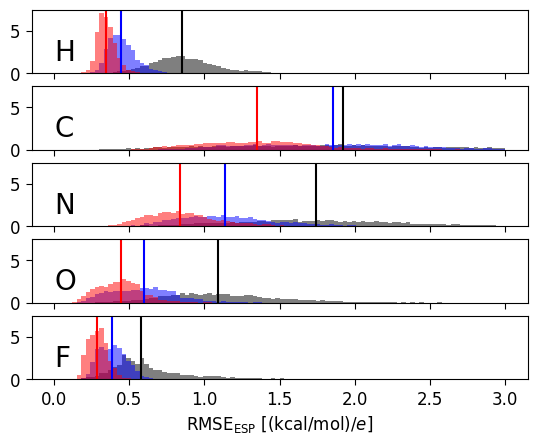

In [116]:
Zs = [1, 6, 7, 8, 9]
atom_types = ["H", "C", "N", "O", "F"]
fig, axes = plt.subplots(5, sharex=True, sharey=True)
for i in range(len(Zs)):
    tmp_df = atom_esp_df[atom_esp_df["Z"] == Zs[i]]
    axes[i].hist(tmp_df["mono"], alpha=0.5, density=True, bins=100, range=(0,3), color="k")
    axes[i].hist(tmp_df["dipo"], alpha=0.5, density=True, bins=100, range=(0,3), color="b")
    axes[i].hist(tmp_df["quad"], alpha=0.5, density=True, bins=100, range=(0,3), color="r")
    axes[i].axvline(tmp_df["mono"].median(), color="k")
    axes[i].axvline(tmp_df["dipo"].median(), color="b")
    axes[i].axvline(tmp_df["quad"].median(), color="r")
    axes[i].text(0, 1.5, atom_types[i], fontsize=20)

axes[-1].set_xlabel("RMSE$_{\mathrm{ESP}}$ [(kcal/mol)/$e$]")

In [14]:
len(data.keys())

6506

In [13]:
analysis_dirs = list(Path("/pchem-data/meuwly/boittier/home/analysis/").glob("202410*dcm*"))
# mbisdata = mbis.glob("*pkl")

In [88]:
for i, _ in enumerate(analysis_dirs):
    print(i, _)

0 /pchem-data/meuwly/boittier/home/analysis/20241002-180908dcm-4-w-10000
1 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-3-w-10000
2 /pchem-data/meuwly/boittier/home/analysis/20241002-175338dcm-2-w-10000
3 /pchem-data/meuwly/boittier/home/analysis/20241002-174336dcm-2-w-10000
4 /pchem-data/meuwly/boittier/home/analysis/20241002-180732dcm-3-w-10000
5 /pchem-data/meuwly/boittier/home/analysis/20241002-180916dcm-2-w-10000
6 /pchem-data/meuwly/boittier/home/analysis/20241002-180941dcm-2-w-10000
7 /pchem-data/meuwly/boittier/home/analysis/20241002-180943dcm-4-w-10000
8 /pchem-data/meuwly/boittier/home/analysis/20241002-180930dcm-4-w-10000
9 /pchem-data/meuwly/boittier/home/analysis/20241002-180931dcm-3-w-10000
10 /pchem-data/meuwly/boittier/home/analysis/20241002-182242dcm-4-w-10000
11 /pchem-data/meuwly/boittier/home/analysis/20241002-182301dcm-3-w-10000


In [89]:
pickles = [list(_.glob("*pkl")) for _ in analysis_dirs]


In [95]:
model_data1 = {_.stem: pd.read_pickle(_) for _ in pickles[2]}
model_atom_esp_dfs1 = []
for k in tqdm(keys[::]):
    _ = pd.DataFrame(esp_rmse_atoms_model(model_data1[k], data[k]["esp"])).T
    _ = _.rename(columns={ 0: "Z", 1:"model",  2: "npoints"})
    _["id"] = k
    model_atom_esp_dfs1.append(_)
    
model_data2 = {_.stem: pd.read_pickle(_) for _ in pickles[11]}
model_atom_esp_dfs2 = []
for k in tqdm(keys[::]):
    _ = pd.DataFrame(esp_rmse_atoms_model(model_data2[k], data[k]["esp"])).T
    _ = _.rename(columns={ 0: "Z", 1:"model",  2: "npoints"})
    _["id"] = k
    model_atom_esp_dfs2.append(_)
    
model_data3 = {_.stem: pd.read_pickle(_) for _ in pickles[10]}
model_atom_esp_dfs3 = []
for k in tqdm(keys[::]):
    _ = pd.DataFrame(esp_rmse_atoms_model(model_data3[k], data[k]["esp"])).T
    _ = _.rename(columns={ 0: "Z", 1:"model",  2: "npoints"})
    _["id"] = k
    model_atom_esp_dfs3.append(_)

100%|████████████████████████████████████████████████████████████████████████████████████████| 6506/6506 [00:04<00:00, 1409.02it/s]


In [96]:
model_atom_esp_df1 = pd.concat(model_atom_esp_dfs1)
model_atom_esp_df2 = pd.concat(model_atom_esp_dfs2)
model_atom_esp_df3 = pd.concat(model_atom_esp_dfs3)

In [100]:
model_atom_esp_df1.describe()

Z         model       npoints
count  32530.00000  25665.000000  25665.000000
mean       6.20000      0.989915    750.824625
std        2.78572      0.563738    831.750593
min        1.00000      0.030886      1.000000
25%        6.00000      0.616590     97.000000
50%        7.00000      0.851769    376.000000
75%        8.00000      1.230632   1201.000000
max        9.00000     14.177443   3102.000000

In [101]:
model_atom_esp_df2.describe()

Z         model       npoints
count  32530.00000  25665.000000  25665.000000
mean       6.20000      0.761480    750.824625
std        2.78572      0.425768    831.750593
min        1.00000      0.018567      1.000000
25%        6.00000      0.494701     97.000000
50%        7.00000      0.667231    376.000000
75%        8.00000      0.925521   1201.000000
max        9.00000     11.132320   3102.000000

In [102]:
model_atom_esp_df3.describe()

Z         model       npoints
count  32530.00000  25665.000000  25665.000000
mean       6.20000      0.723854    750.824625
std        2.78572      0.415558    831.750593
min        1.00000      0.018217      1.000000
25%        6.00000      0.472660     97.000000
50%        7.00000      0.624173    376.000000
75%        8.00000      0.858569   1201.000000
max        9.00000      8.639974   3102.000000

Text(0.5, 0, 'RMSE$_{\\mathrm{ESP}}$ [(kcal/mol)/$e$]')

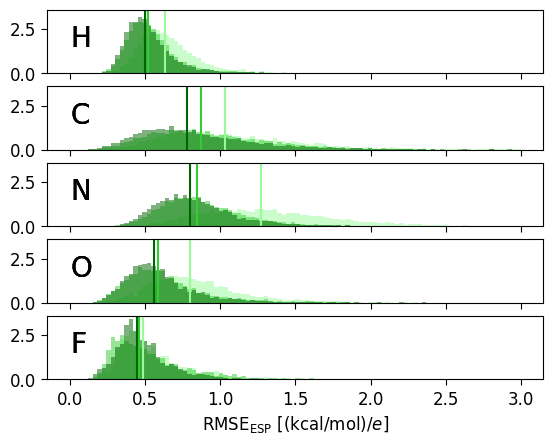

In [110]:
Zs = [1, 6, 7, 8, 9]
atom_types = ["H", "C", "N", "O", "F"]
fig, axes = plt.subplots(5, sharex=True, sharey=True)
for i in range(len(Zs)):
    tmp_df = model_atom_esp_df1[model_atom_esp_df1["Z"] == Zs[i]]
    axes[i].hist(tmp_df["model"], alpha=0.5, density=True, bins=100, range=(0,3), color="palegreen")
    axes[i].axvline(tmp_df["model"].median(), color="palegreen")
    axes[i].text(0, 1.5, atom_types[i], fontsize=20)
    
    tmp_df = model_atom_esp_df2[model_atom_esp_df2["Z"] == Zs[i]]
    axes[i].hist(tmp_df["model"], alpha=0.5, density=True, bins=100, range=(0,3), color="limegreen")
    axes[i].axvline(tmp_df["model"].median(), color="limegreen")
    axes[i].text(0, 1.5, atom_types[i], fontsize=20)
    
    tmp_df = model_atom_esp_df3[model_atom_esp_df3["Z"] == Zs[i]]
    axes[i].hist(tmp_df["model"], alpha=0.5, density=True, bins=100, range=(0,3), color="darkgreen")
    axes[i].axvline(tmp_df["model"].median(), color="darkgreen")
    axes[i].text(0, 1.5, atom_types[i], fontsize=20)

axes[-1].set_xlabel("RMSE$_{\mathrm{ESP}}$ [(kcal/mol)/$e$]")

In [45]:
import rdkit
from rdkit.Chem import Draw

In [46]:
datadir = Path("/pchem-data/meuwly/boittier/home/jaxeq/")

In [47]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    # 126907,
    6907,
    [
        # datadir / "data/qm9-esp-dip-40000-0.npz", 
        # datadir / "data/qm9-esp-dip-40000-1.npz", 
        # datadir / "data/qm9-esp-dip-40000-2.npz", 
        datadir / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [48]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [49]:
import ase.data

In [50]:
def batch_to_xyzblock(batch):
    block = ""
    xyz_str = ""
    count = 0
    for elem, xyz in zip(batch["Z"], batch["R"]):
        if elem != 0:
            count+=1
            xyz_str += "{} {}\n".format(ase.data.chemical_symbols[elem], " ".join([f"{_:.3f}" for _ in xyz]))
    block += f"{count}\n\n"
    block += xyz_str
    return block

In [ ]:
# https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDetermineBonds
def xyz_to_pdb_block(xyz_block):
    pdb_block = ''
    n = 0
    n_atoms = 0
    with StringIO(xyz_block) as hnd:
        while True:
            line = hnd.readline()
            if (not line):
                raise RuntimeError('XYZ block ended prematurely')
            n += 1
            if (n == 1):
                try:
                    n_atoms = int(line.strip())
                except Exception as e:
                    raise type(e)('Could not parse number of atoms on line {0:d}'.format(n)) from e
            elif (n > 2):
                try:
                    elem, x, y, z = line.strip().split()
                except Exception as e:
                    raise type(e)('Could not parse coordinate line {0:d}'.format(n)) from e
                pdb_block += 'ATOM  {0:5d} {1:>2s}   UNL     1    {2:8.3f}{3:8.3f}{4:8.3f}  1.00  0.00\n'.format(
                    n - 2, elem, float(x), float(y), float(z))
                if (n == n_atoms + 2):
                    break
    return pdb_block   

import py3Dmol
def draw_with_spheres(mol):
    v = py3Dmol.view(width=300,height=300)
    IPythonConsole.addMolToView(mol,v)
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
    v.show()

In [ ]:
# from pybel import readstring
import openbabel
from openbabel import pybel

In [ ]:
relax_fails = []
gdb_fails = []

for i in range(len(valid_batches)):
    batch = valid_batches[i]
    fn = str(batch["id"][0])
    block = batch_to_xyzblock(batch)
    mols = get_mol_from_id(batch)
    m0 = mols[0]
    
    try:
        smi = Chem.CanonSmiles(Chem.MolToSmiles(m0))
    except:
        smi = None
        continue
        
    mol = Chem.MolFromXYZBlock(block)
    if mol is None:
        print(f'Could not parse {fn}')
        continue
    try:
        rdDetermineBonds.DetermineBonds(mol,charge=0)
        pdb = Chem.MolToPDBBlock(mol)
        pybel_mol = pybel.readstring("pdb", pdb)
        mol2_string = pybel_mol.write("mol2")
        with open(Path("/pchem-data/meuwly/boittier/home/jaxeq/") / f"{fn}.mol2", "w") as f:
            f.write(mol2_string)
    except:
        print("determine bonds failed")
        continue


    
    # remove double bond stereo:
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond.SetStereo(Chem.BondStereo.STEREONONE)
        elif bond.GetBondType() == Chem.BondType.SINGLE:
            bond.SetBondDir(Chem.BondDir.NONE)
    osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
    # compare to relax_smi:
    # print(smi, osmi)
    if smi!=osmi:
        relax_fails.append((fn,smi,osmi))
        gdb_smi=smi
        # that failed, so next we are going to compare to gdb_smi;
        try:
            smi = Chem.CanonSmiles(gdb_smi)
        except:
            continue
        # the GDB smiles don't have any stereo at all, so get rid of atomic stereo
        for atom in mol.GetAtoms():
            atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
        if smi != osmi:
            gdb_fails.append((fn,smi,osmi))
        

In [ ]:
import ase


In [3]:
ase_obj = ase.Atoms(batch["Z"], batch["R"])
ase.visualize.view(ase_obj, viewer="x3d")


NameError: name 'ase' is not defined

In [4]:
mol = Chem.MolFromXYZBlock(block)
if mol is None:
    print(f'Could not parse {fn}')
rdDetermineBonds.DetermineBonds(mol,charge=0)

draw_with_spheres(mol)

NameError: name 'Chem' is not defined

In [106]:
draw_with_spheres(m0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [173]:
gdb_fails

[('dsgdb9nsd_121896', 'COCCC([NH3+])C(=O)[O-]', 'COCCC(N)C(=O)O'),
 ('dsgdb9nsd_060635', '[NH3+]C1CC1C(O)C(=O)[O-]', 'NC1CC1C(O)C(=O)O'),
 ('dsgdb9nsd_098239', 'CNC(=O)C([NH3+])C(=O)[O-]', 'CNC(=O)C(N)C(=O)O'),
 ('dsgdb9nsd_005598', '[NH3+]Cc1ccoc1[O-]', 'NCc1ccoc1O'),
 ('dsgdb9nsd_102795', 'N=COC(C[NH3+])C(=O)[O-]', 'NCC1OC(N)OC1=O'),
 ('dsgdb9nsd_060429', 'CC(C)[NH2+]CCC(=O)[O-]', 'CC(C)NCCC(=O)O'),
 ('dsgdb9nsd_022265', 'CC(=N[O-])C1(O)C[NH2+]C1', 'CC(=[NH+][O-])C1(O)CNC1'),
 ('dsgdb9nsd_006792', '[NH3+]CCOCC(=O)[O-]', 'NCCOCC(=O)O'),
 ('dsgdb9nsd_086827', '[NH3+]C1CC(CC(=O)[O-])C1', 'NC1CC(CC(=O)O)C1'),
 ('dsgdb9nsd_127895', 'CN=c1nnoc(O)n1', 'CN=C=NC(=O)O.N#N'),
 ('dsgdb9nsd_113165', 'CCC1CC1([NH3+])C(=O)[O-]', 'CCC1CC1(N)C(=O)O'),
 ('dsgdb9nsd_054179', 'CC1(C(=O)[O-])CN1C=[NH2+]', 'CC12CN1C(N)OC2=O'),
 ('dsgdb9nsd_101926', 'C[NH2+]C(C(=O)[O-])C1CN1', 'CNC(C(=O)O)C1CN1'),
 ('dsgdb9nsd_037993', 'C1=C2CC3N=C1N1C2C31', 'C=C1C=C2N=CC3C1N23'),
 ('dsgdb9nsd_130402', 'N#Cc1[n-]nnc1C[NH3+

In [180]:
len(relax_fails)

85151

In [26]:
parms = list(Path("/pchem-data/meuwly/boittier/home/qm9mol2").glob("*parm"))

In [27]:
parms

[PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126730.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126731.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126732.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126733.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126734.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126735.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126736.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126737.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126738.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126739.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126740.mol2.parm'),
 PosixPath('/pchem-data/meuwly/boittier/home/qm9mol2/dsgdb9nsd_126741.mol2.parm'),
 Pos

In [28]:
cgenff_parms = {}
for fn in parms:
    with open(fn) as f:
        lines = f.readlines()
        atoms = []
        for _ in lines:
            if _.__contains__("ATOM"):
                atoms.append(_)
        qm9_key = str(fn.stem).strip(".mol2")
        print(qm9_key)
        qm9_key = "dsgdb9nsd_" + "{:06}".format(int(qm9_key.split("_")[1]))
        print(qm9_key)
        cgenff_parms[qm9_key] = atoms

dsgdb9nsd_126730
dsgdb9nsd_126730
dsgdb9nsd_126731
dsgdb9nsd_126731
dsgdb9nsd_12673
dsgdb9nsd_012673
dsgdb9nsd_126733
dsgdb9nsd_126733
dsgdb9nsd_126734
dsgdb9nsd_126734
dsgdb9nsd_126735
dsgdb9nsd_126735
dsgdb9nsd_126736
dsgdb9nsd_126736
dsgdb9nsd_126737
dsgdb9nsd_126737
dsgdb9nsd_126738
dsgdb9nsd_126738
dsgdb9nsd_126739
dsgdb9nsd_126739
dsgdb9nsd_126740
dsgdb9nsd_126740
dsgdb9nsd_126741
dsgdb9nsd_126741
dsgdb9nsd_12674
dsgdb9nsd_012674
dsgdb9nsd_126743
dsgdb9nsd_126743
dsgdb9nsd_126744
dsgdb9nsd_126744
dsgdb9nsd_126745
dsgdb9nsd_126745
dsgdb9nsd_126746
dsgdb9nsd_126746
dsgdb9nsd_126747
dsgdb9nsd_126747
dsgdb9nsd_126748
dsgdb9nsd_126748
dsgdb9nsd_126749
dsgdb9nsd_126749
dsgdb9nsd_126750
dsgdb9nsd_126750
dsgdb9nsd_126751
dsgdb9nsd_126751
dsgdb9nsd_12675
dsgdb9nsd_012675
dsgdb9nsd_126754
dsgdb9nsd_126754
dsgdb9nsd_126755
dsgdb9nsd_126755
dsgdb9nsd_126756
dsgdb9nsd_126756
dsgdb9nsd_126757
dsgdb9nsd_126757
dsgdb9nsd_126758
dsgdb9nsd_126758
dsgdb9nsd_126759
dsgdb9nsd_126759
dsgdb9nsd_126760


In [30]:
cgenff_parms["dsgdb9nsd_126730"]

['ATOM C1     CG331  -0.258 !    2.250\n',
 'ATOM C2     CG321   0.057 !   26.273\n',
 'ATOM N1     NG2R61 -0.054 !  176.867\n',
 'ATOM C3     CG2R61 -0.253 !   43.984\n',
 'ATOM C4     CG2R61 -0.137 !   34.664\n',
 'ATOM C5     CG2R64  0.976 !   22.663\n',
 'ATOM N2     NG2D1  -0.875 !   14.402\n',
 'ATOM N3     NG2R62 -0.433 !   26.449\n',
 'ATOM N4     NG2R62 -0.167 !  177.634\n',
 'ATOM H1     HGA3    0.090 !    0.000\n',
 'ATOM H2     HGA3    0.090 !    0.000\n',
 'ATOM H3     HGA3    0.090 !    0.000\n',
 'ATOM H4     HGA2    0.090 !    2.250\n',
 'ATOM H5     HGA2    0.090 !    2.250\n',
 'ATOM H6     HGR62   0.220 !   27.040\n',
 'ATOM H7     HGR61   0.154 !    0.000\n',
 'ATOM H8     HGP1    0.320 !    0.000\n']

In [51]:
[str(_["id"][0]) for _ in valid_batches[:10]]

['dsgdb9nsd_131371',
 'dsgdb9nsd_132759',
 'dsgdb9nsd_126821',
 'dsgdb9nsd_133460',
 'dsgdb9nsd_131240',
 'dsgdb9nsd_130519',
 'dsgdb9nsd_131833',
 'dsgdb9nsd_128509',
 'dsgdb9nsd_131838',
 'dsgdb9nsd_132401']

In [52]:
def str_to_alpha(s):
    return "".join(filter(lambda x: x.isalpha(), s))

In [53]:
valid_ids = set([str(_["id"][0]) for _ in valid_batches if str(_["id"][0])])

In [54]:
valid_ids

{'dsgdb9nsd_131126',
 'dsgdb9nsd_130644',
 'dsgdb9nsd_132596',
 'dsgdb9nsd_129434',
 'dsgdb9nsd_127431',
 'dsgdb9nsd_131259',
 'dsgdb9nsd_129228',
 'dsgdb9nsd_131356',
 'dsgdb9nsd_127697',
 'dsgdb9nsd_128414',
 'dsgdb9nsd_127749',
 'dsgdb9nsd_133657',
 'dsgdb9nsd_129811',
 'dsgdb9nsd_133883',
 'dsgdb9nsd_129911',
 'dsgdb9nsd_126961',
 'dsgdb9nsd_128255',
 'dsgdb9nsd_133693',
 'dsgdb9nsd_131235',
 'dsgdb9nsd_128698',
 'dsgdb9nsd_133879',
 'dsgdb9nsd_127957',
 'dsgdb9nsd_127287',
 'dsgdb9nsd_133284',
 'dsgdb9nsd_132823',
 'dsgdb9nsd_132381',
 'dsgdb9nsd_131690',
 'dsgdb9nsd_133769',
 'dsgdb9nsd_128905',
 'dsgdb9nsd_130322',
 'dsgdb9nsd_132459',
 'dsgdb9nsd_130814',
 'dsgdb9nsd_130217',
 'dsgdb9nsd_132530',
 'dsgdb9nsd_133340',
 'dsgdb9nsd_130859',
 'dsgdb9nsd_132569',
 'dsgdb9nsd_133429',
 'dsgdb9nsd_127446',
 'dsgdb9nsd_131621',
 'dsgdb9nsd_126772',
 'dsgdb9nsd_131425',
 'dsgdb9nsd_129248',
 'dsgdb9nsd_128068',
 'dsgdb9nsd_133795',
 'dsgdb9nsd_132274',
 'dsgdb9nsd_127004',
 'dsgdb9nsd_1

In [56]:
keys = list(cgenff_parms.keys())
cgenff_keys = set(keys)

In [57]:
len(cgenff_keys)

6588

In [58]:
len(valid_ids)

6621

In [59]:
len(cgenff_keys & valid_ids)

5926

In [72]:
qm9_id = []
atom_id = []
mbis_q = []
cgenff_q = []
elements = []
atom_number = []
for key in keys:
    elem = [str_to_alpha(str(_.split()[1])) for _ in cgenff_parms[key]]
    cgenff_charges = [float(_.split()[3]) for _ in cgenff_parms[key]]
    cgenff_atomtypes = [str(_.split()[2]) for _ in cgenff_parms[key]]
    try:
        batch = [_ for _ in valid_batches if str(_["id"][0]) == key][0]
        nonzero = batch["Z"] != 0
        mono = batch["mono"][nonzero]
    except Exception as e:
        # print(e, key)
        mono = []
    
    if len(mono) > 0 and len(cgenff_atomtypes) == len(mono):
        # assert len(cgenff_atomtypes) == len(mono), "{} {}".format(len(cgenff_atomtypes), len(mono))
        for i in range(len(mono)):
            qm9_id.append(key)
            atom_id.append(cgenff_atomtypes[i])
            mbis_q.append(mono[i])
            cgenff_q.append(cgenff_charges[i])
            elements.append(elem[i])
            atom_number.append(i)


In [73]:
charge_comparison = pd.DataFrame({
    "qm9_id": qm9_id,
     "atom_id": atom_id,
    "idx": atom_number,
    "element": elements,
     "mbis_q": mbis_q,
     "cgenff_q": cgenff_q,
             })

In [280]:
unique_cgenff = charge_comparison["atom_id"].unique()
counts = charge_comparison[["atom_id", "element"]].groupby("atom_id").describe().element
counts[counts["count"] > 210].index

Index(['CG1N1', 'CG1T1', 'CG1T2', 'CG2O1', 'CG2O4', 'CG2R51', 'CG2R52',
       'CG2R53', 'CG2R61', 'CG2R62', 'CG2R63', 'CG2R64', 'CG2R66', 'CG2R71',
       'CG2RC0', 'CG302', 'CG321', 'CG331', 'CG3C31', 'CG3C41', 'CG3C52',
       'FGA3', 'FGR1', 'HGA1', 'HGA2', 'HGA3', 'HGP1', 'HGP4', 'HGPAM1',
       'HGPAM2', 'HGR51', 'HGR52', 'HGR61', 'HGR62', 'NG1T1', 'NG2D1',
       'NG2R50', 'NG2R51', 'NG2R60', 'NG2R61', 'NG2R62', 'NG2S3', 'NG311',
       'NG321', 'OG2D1', 'OG2D4', 'OG2R50', 'OG301', 'OG311', 'OG3R60'],
      dtype='object', name='atom_id')

In [62]:
len(charge_comparison["qm9_id"].unique())

5913

In [249]:
charge_comparison

qm9_id atom_id  idx element    mbis_q  cgenff_q
0      dsgdb9nsd_126730   CG331    0       C -0.470887    -0.258
1      dsgdb9nsd_126730   CG321    1       C -0.104755     0.057
2      dsgdb9nsd_126730  NG2R61    2       N  0.037714    -0.054
3      dsgdb9nsd_126730  CG2R61    3       C -0.027460    -0.253
4      dsgdb9nsd_126730  CG2R61    4       C -0.341609    -0.137
...                 ...     ...  ...     ...       ...       ...
85752  dsgdb9nsd_133884    HGA1   13       H  0.148707     0.090
85753  dsgdb9nsd_133884    HGA2   14       H  0.130071     0.090
85754  dsgdb9nsd_133884    HGA2   15       H  0.130072     0.090
85755  dsgdb9nsd_133884    HGA1   16       H  0.099798     0.090
85756  dsgdb9nsd_133884    HGA1   17       H  0.153598     0.090

[85757 rows x 6 columns]

In [394]:
charge_comparison.to_csv("charge-comparison.csv")

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def scatter_dens(x, y):

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Sort points by density (for better visualization)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=z, s=50, cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot Colored by Point Density')
    plt.show()

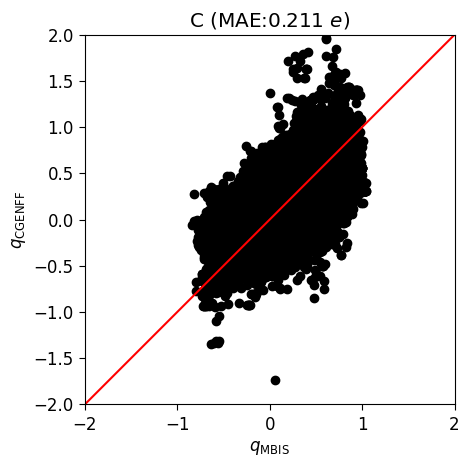

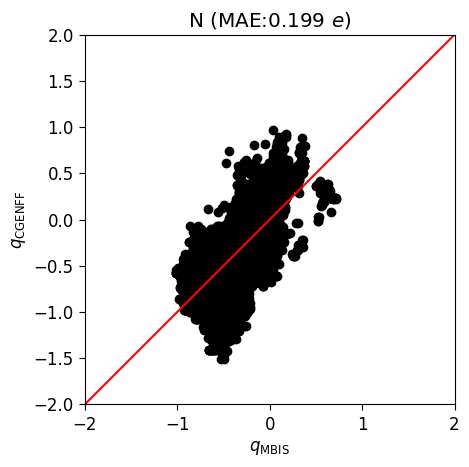

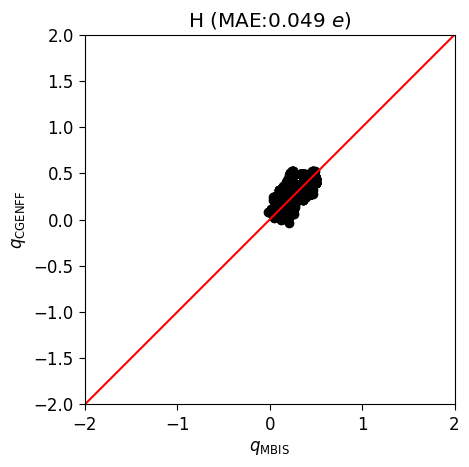

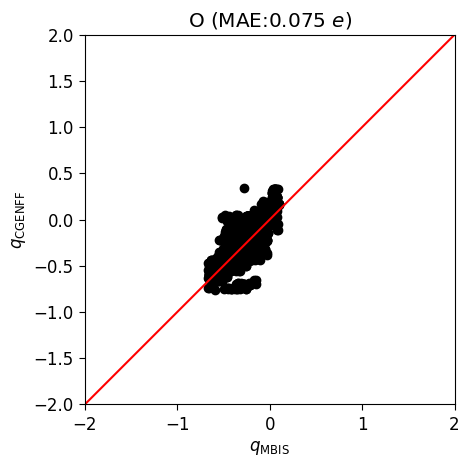

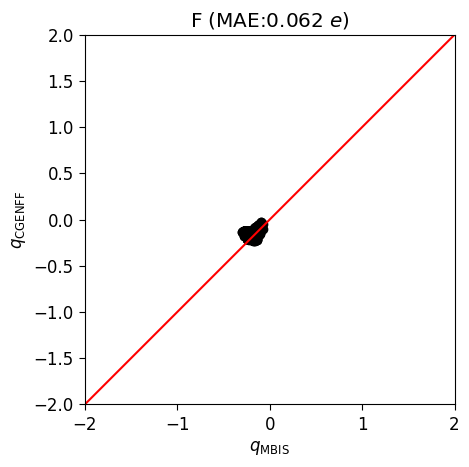

In [64]:
for element in charge_comparison.element.unique():
    _ = charge_comparison[charge_comparison["element"] == element]
    plt.scatter(_["mbis_q"], _["cgenff_q"], alpha=1, color="k")
    plt.plot([-2,2], [-2,2], c="r")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xlabel(r"$q_{\mathrm{MBIS}}$")
    plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
    plt.gca().set_aspect("equal")
    MAE =np.mean(abs( _["mbis_q"] - _["cgenff_q"]))
    title = f"{element} (MAE:{MAE:.3f} $e$)"
    plt.title(title)
    plt.show()

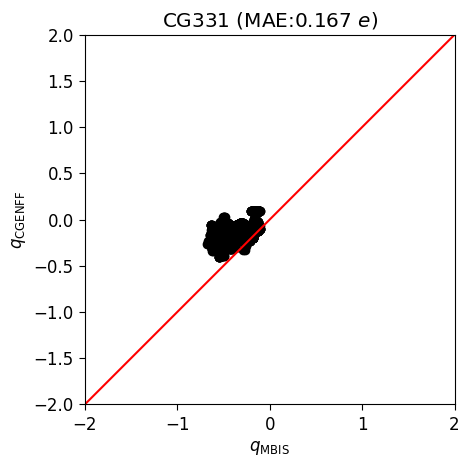

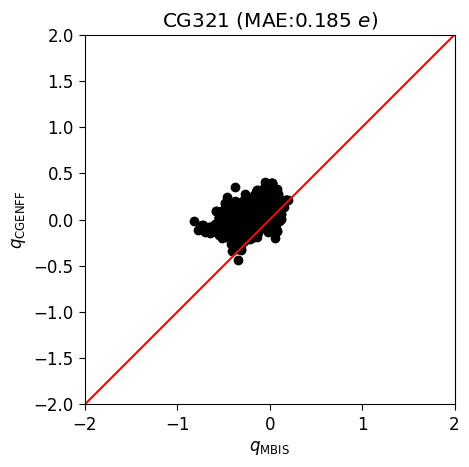

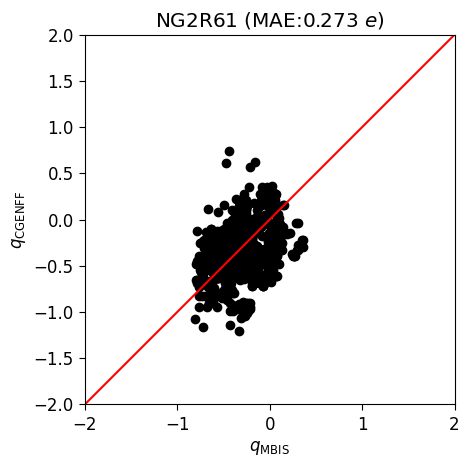

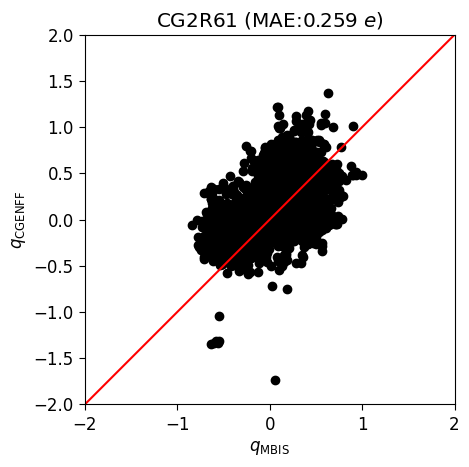

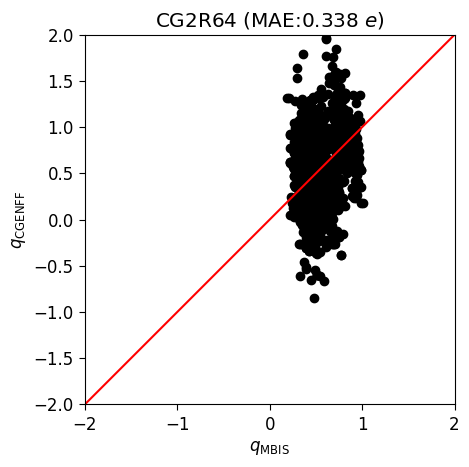

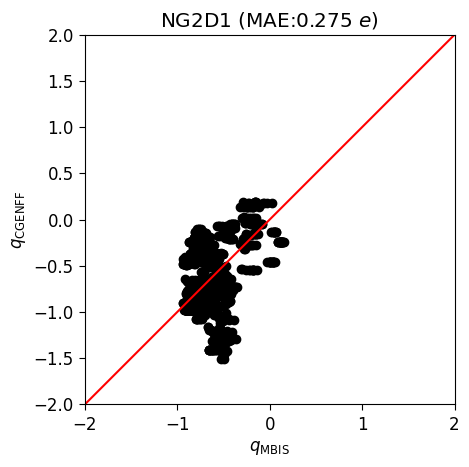

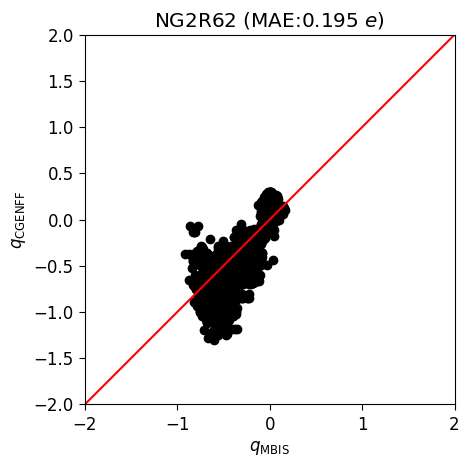

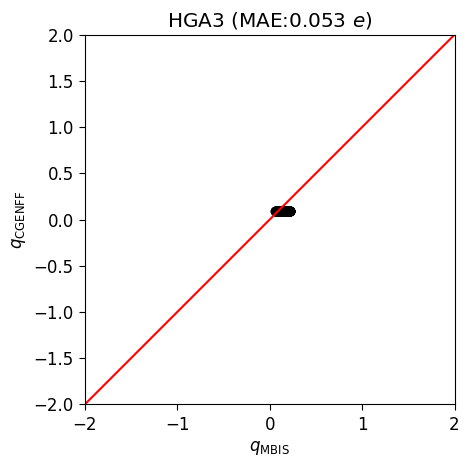

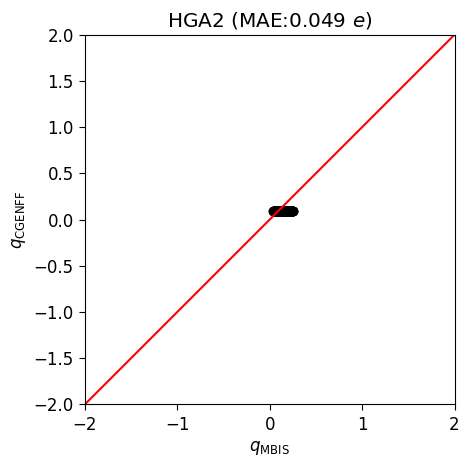

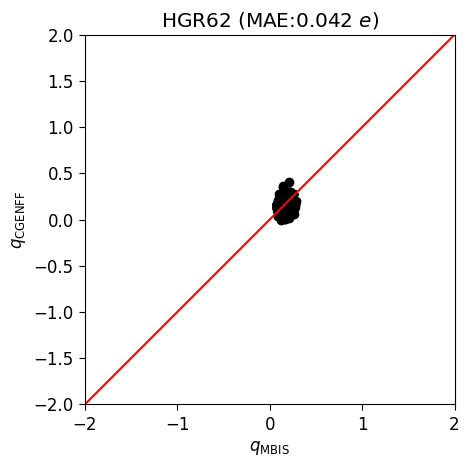

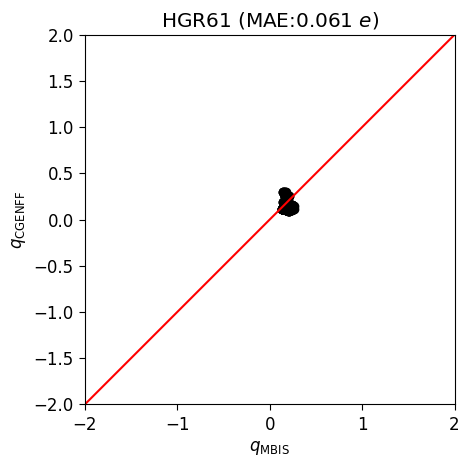

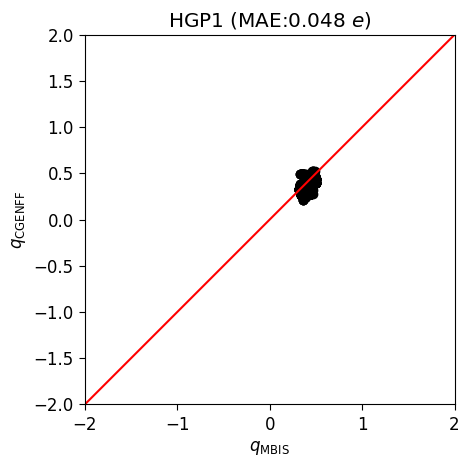

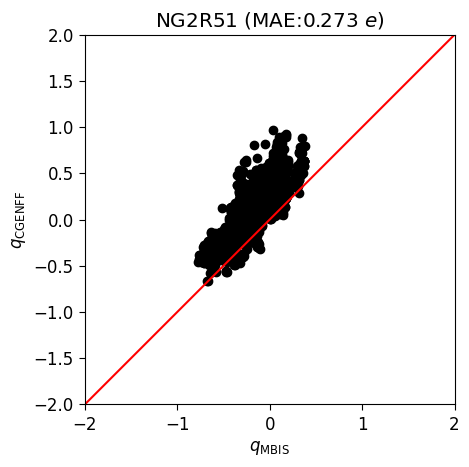

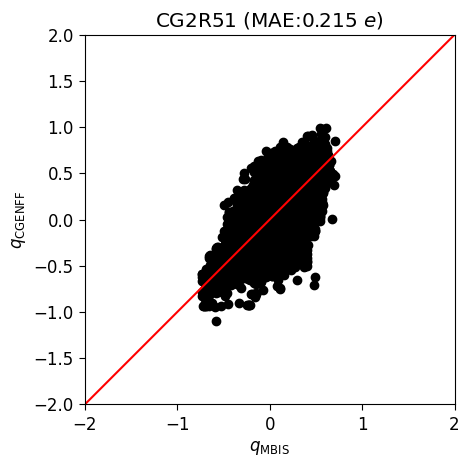

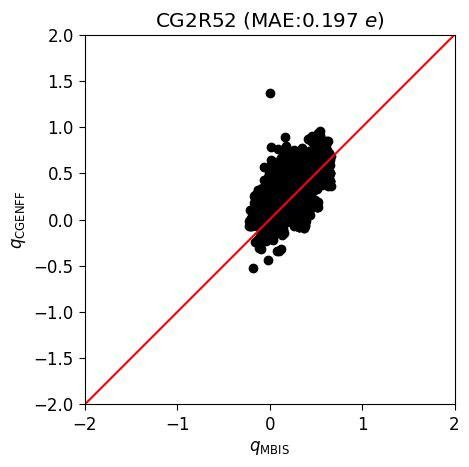

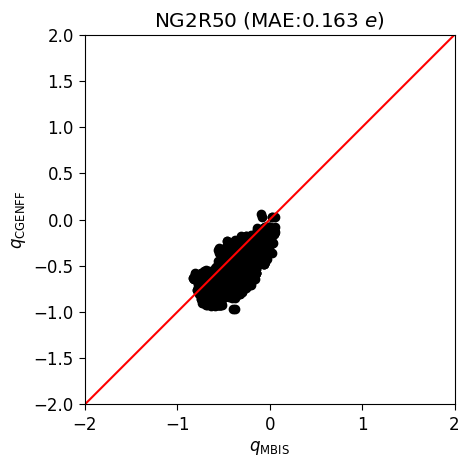

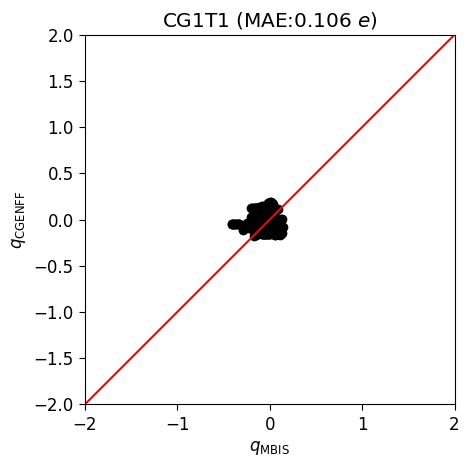

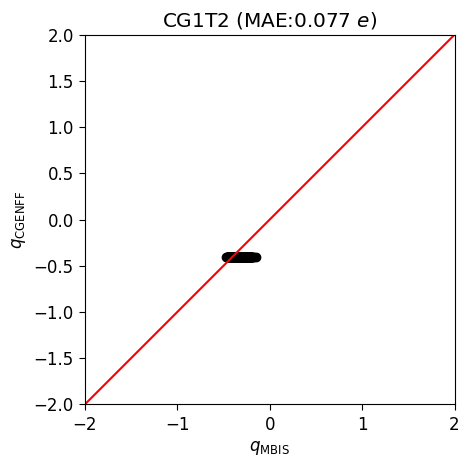

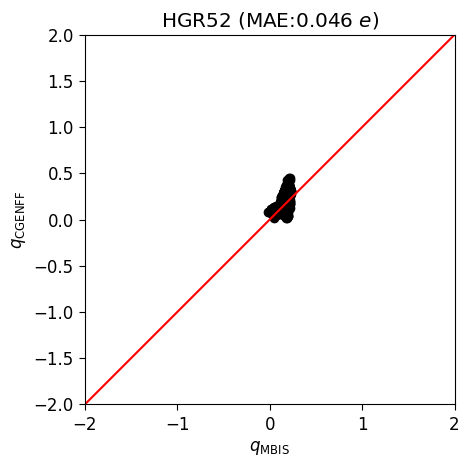

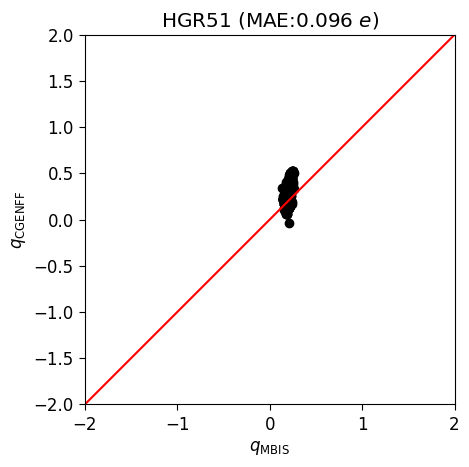

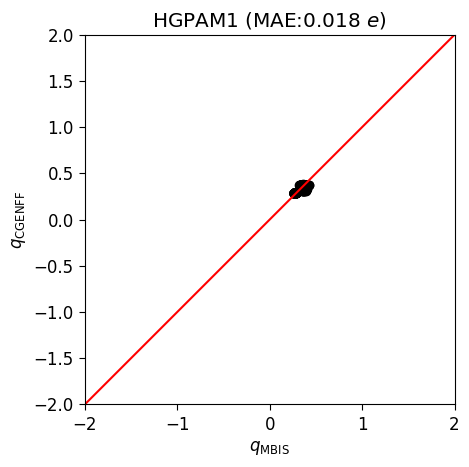

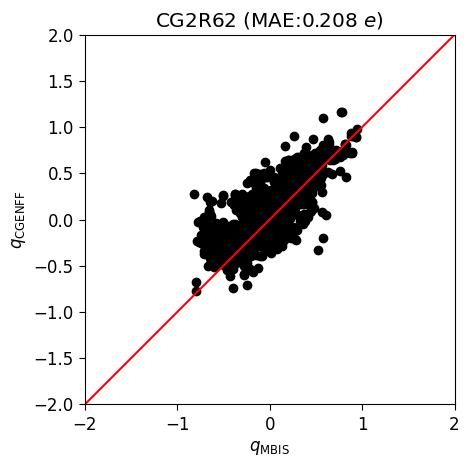

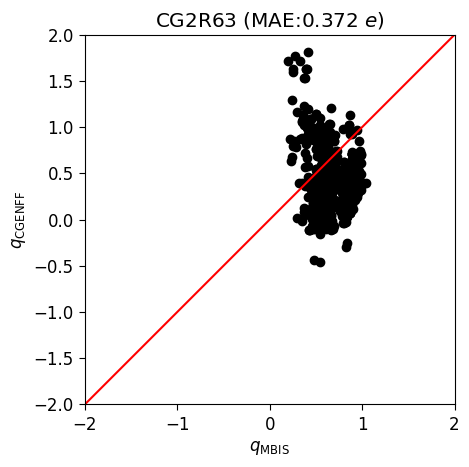

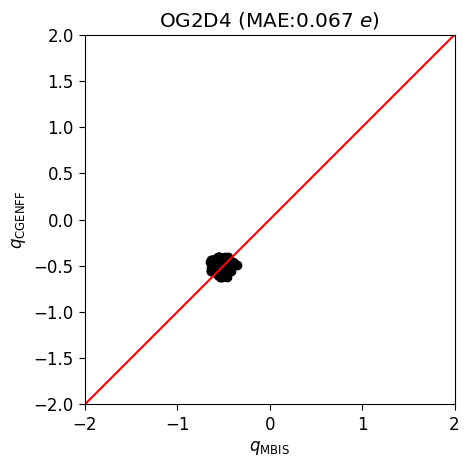

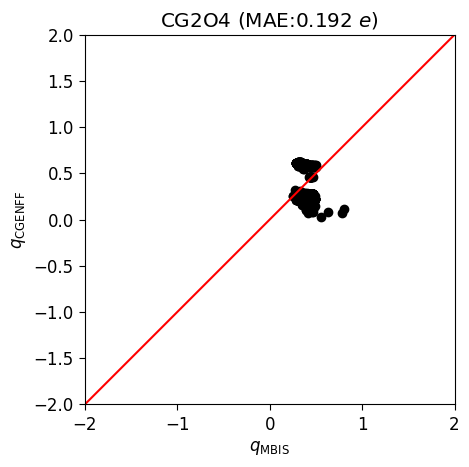

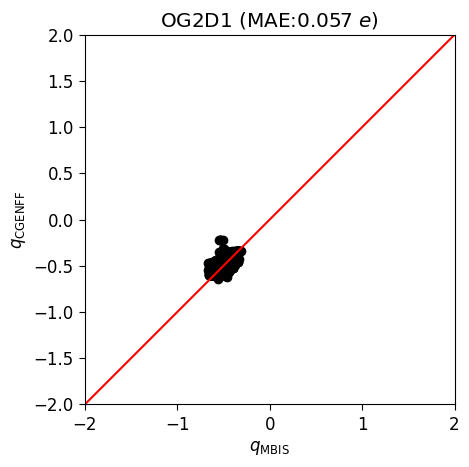

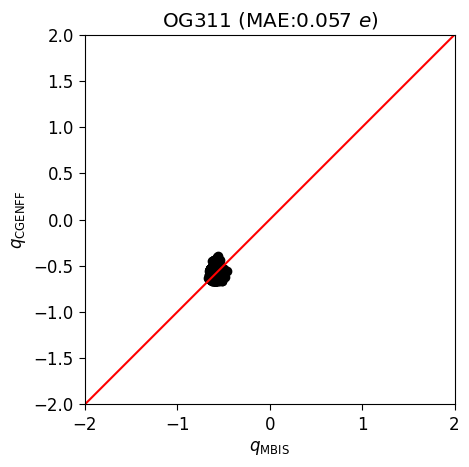

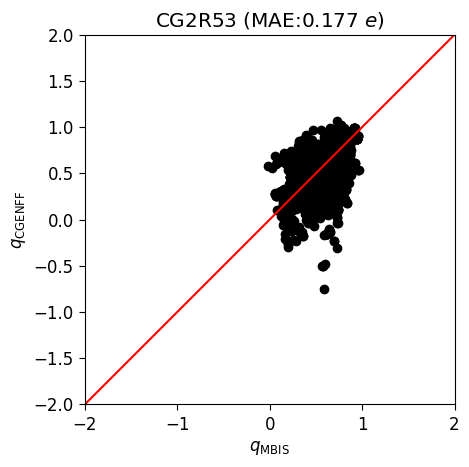

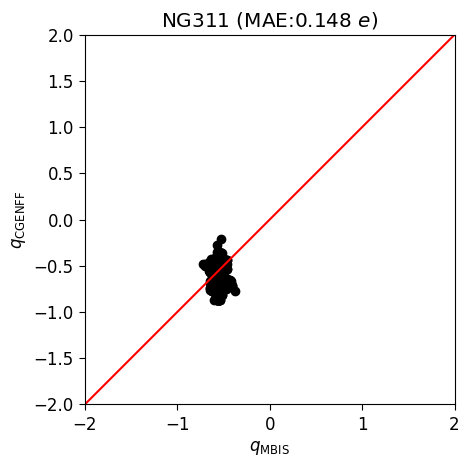

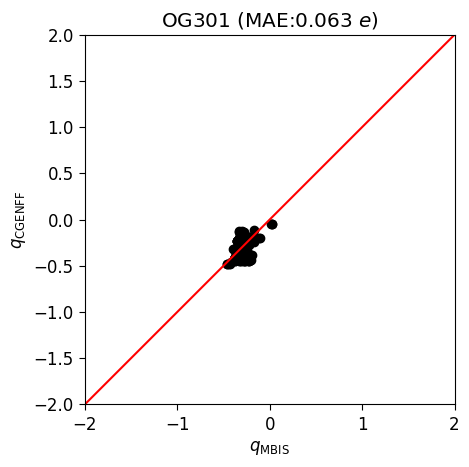

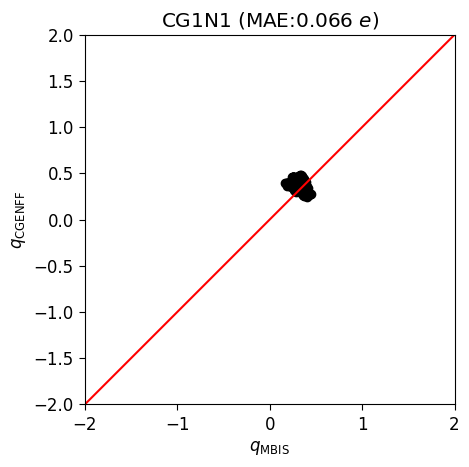

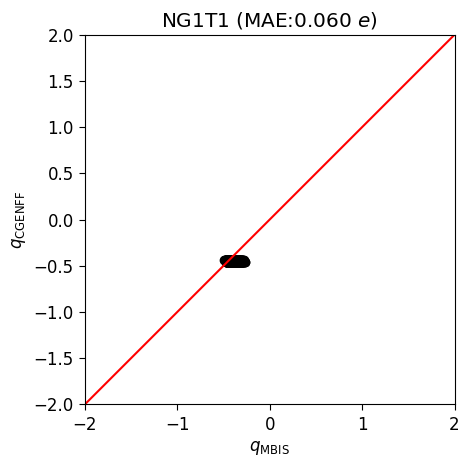

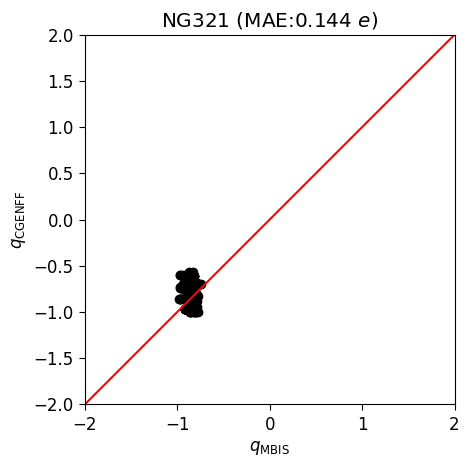

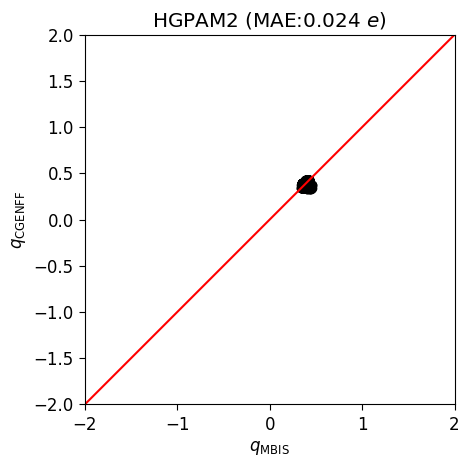

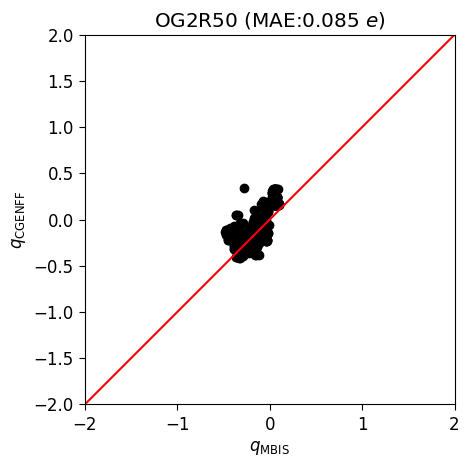

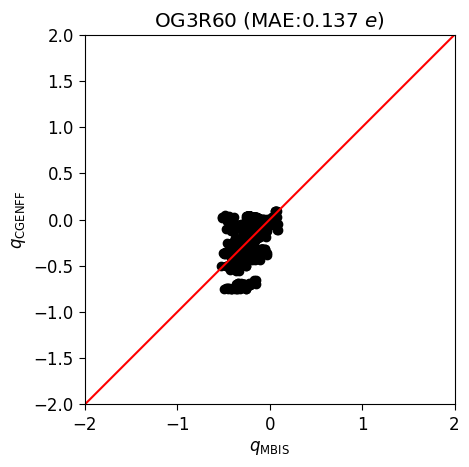

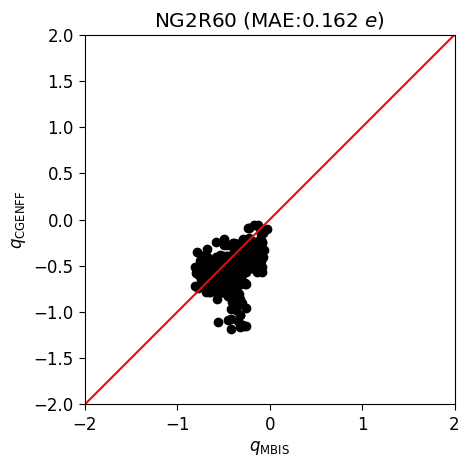

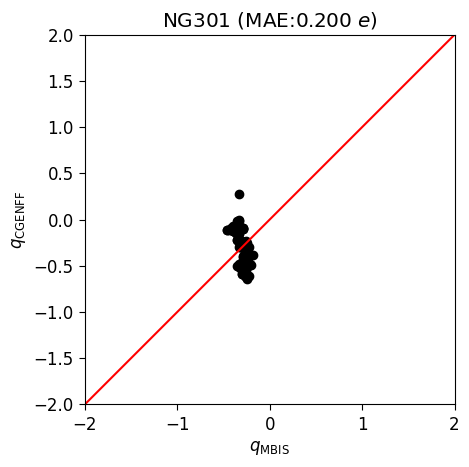

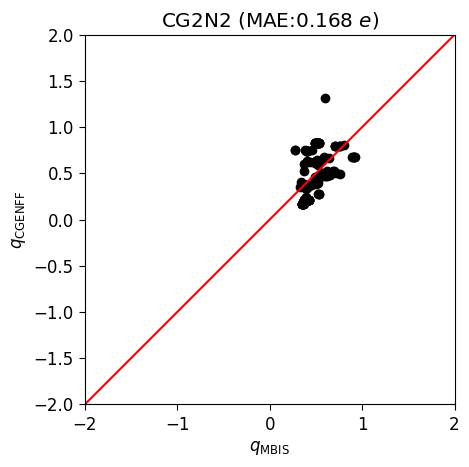

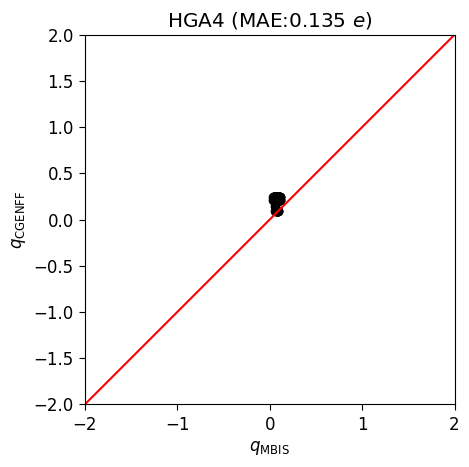

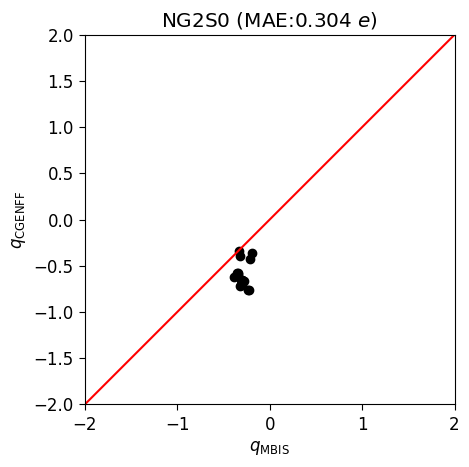

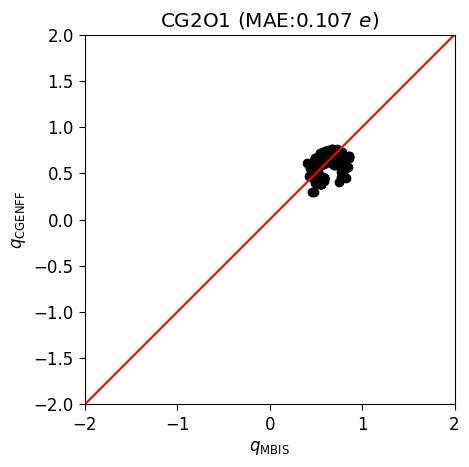

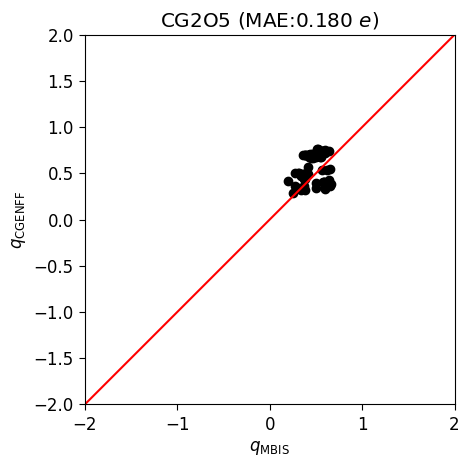

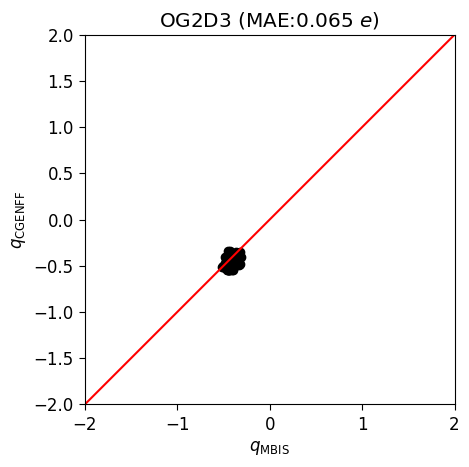

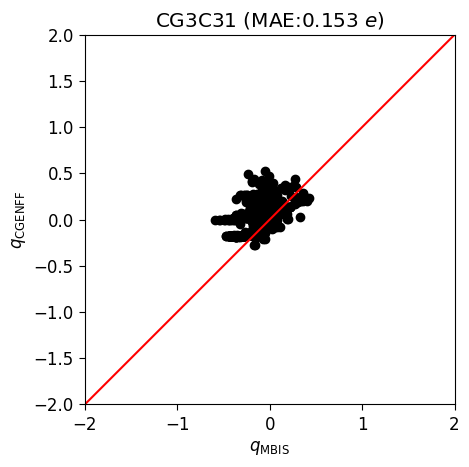

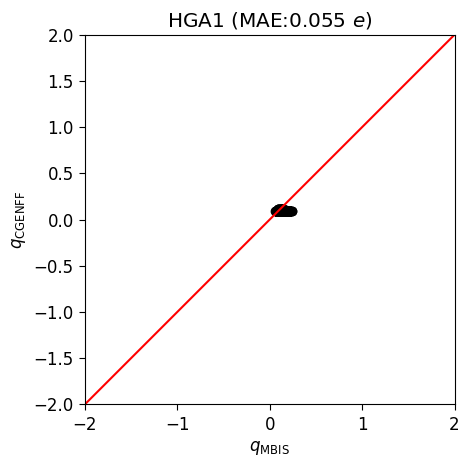

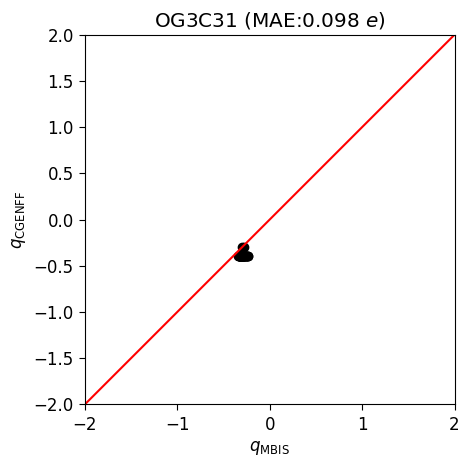

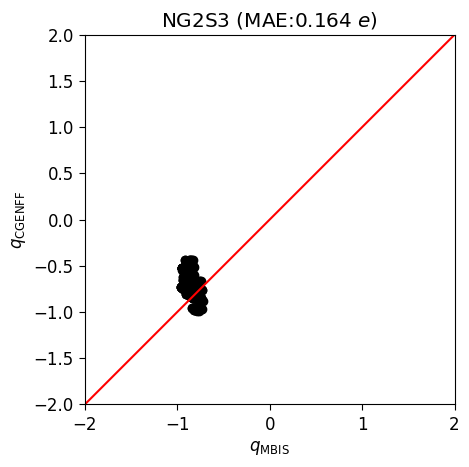

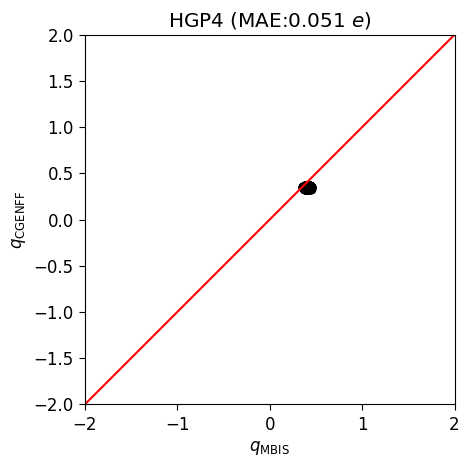

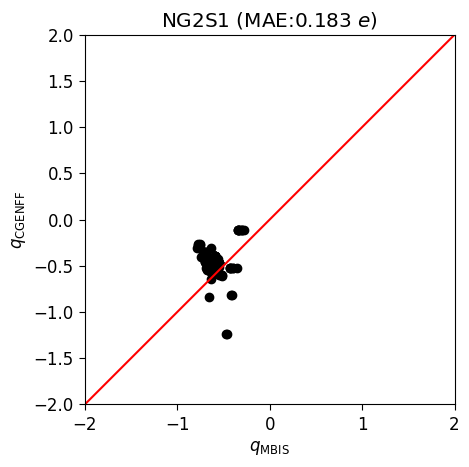

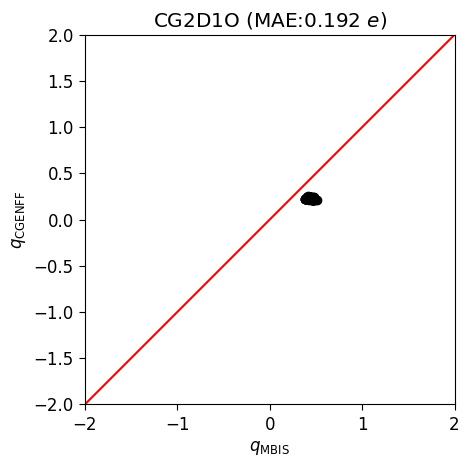

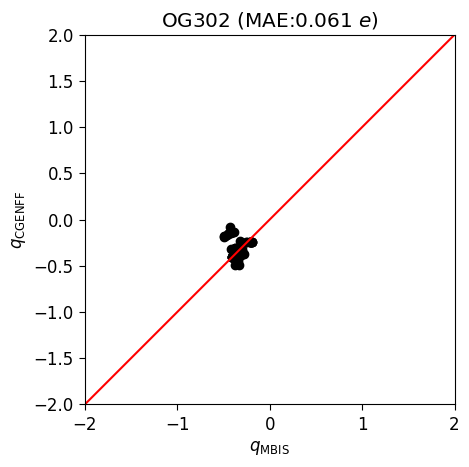

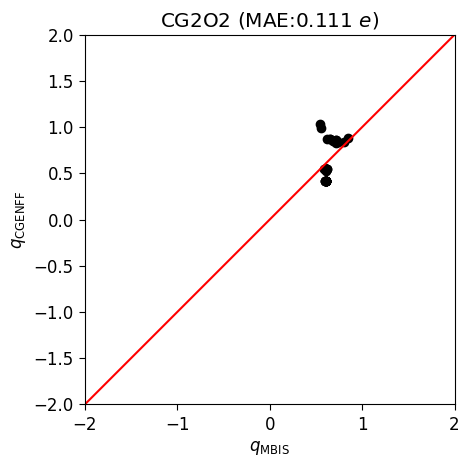

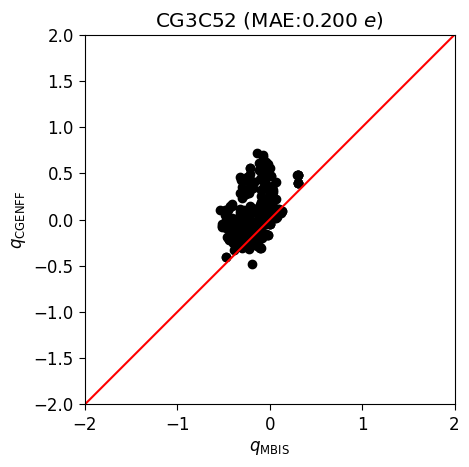

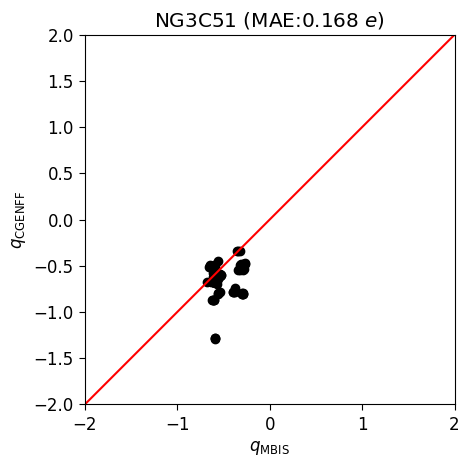

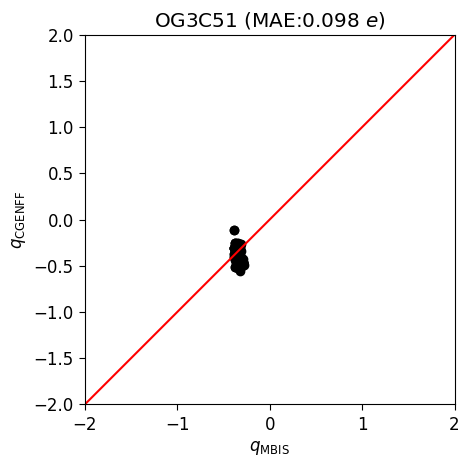

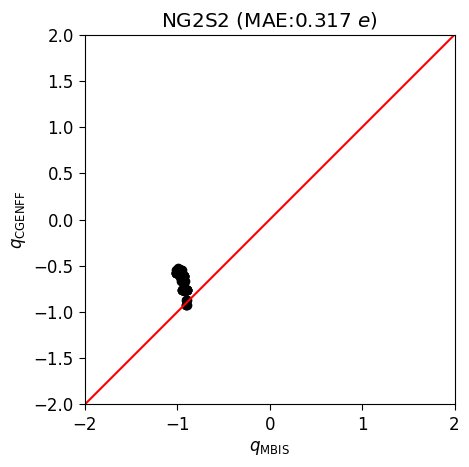

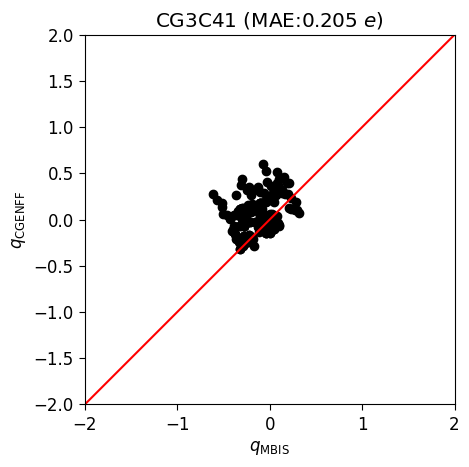

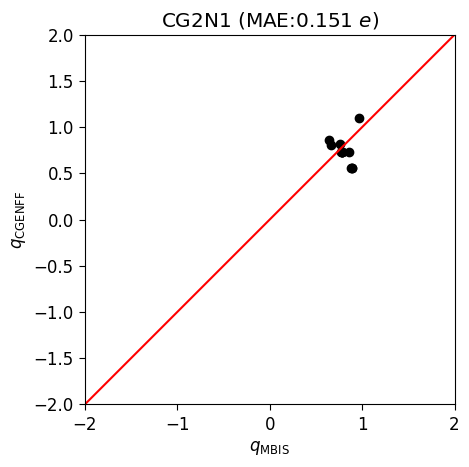

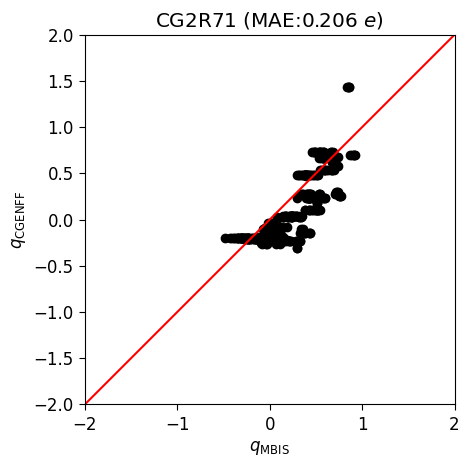

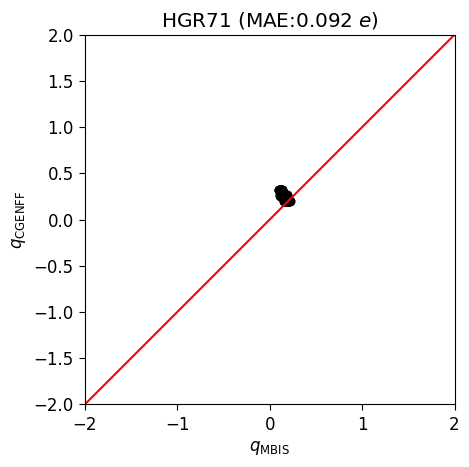

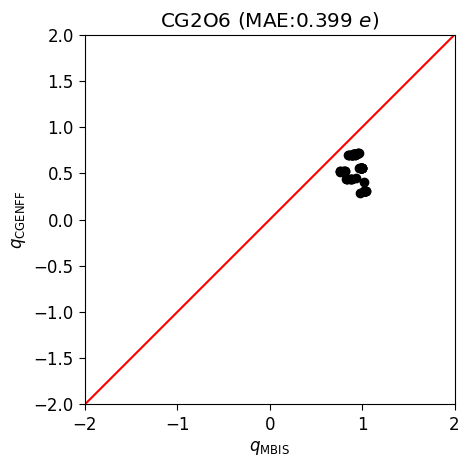

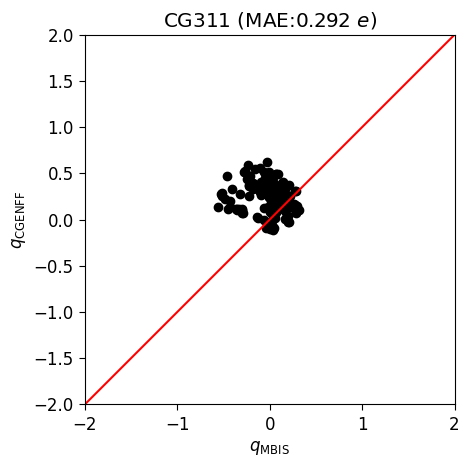

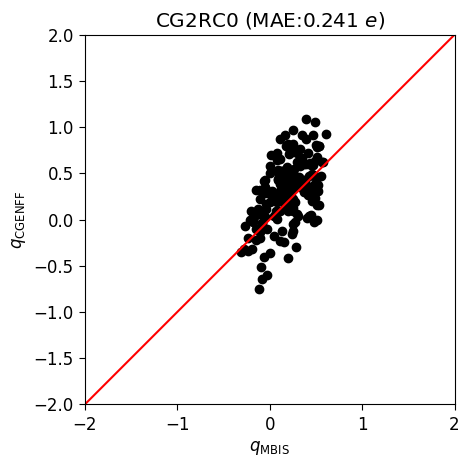

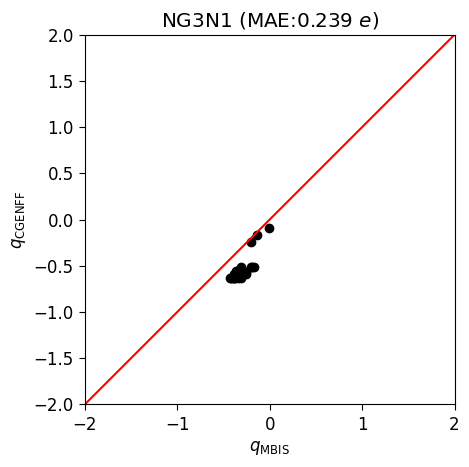

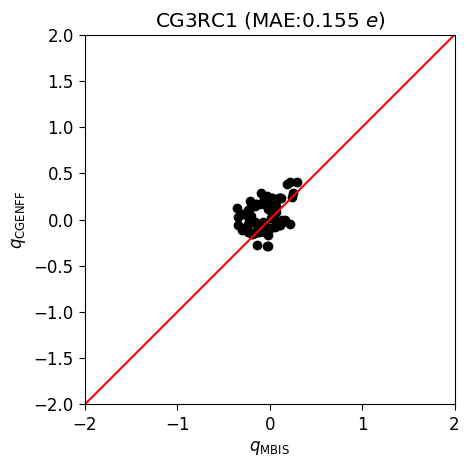

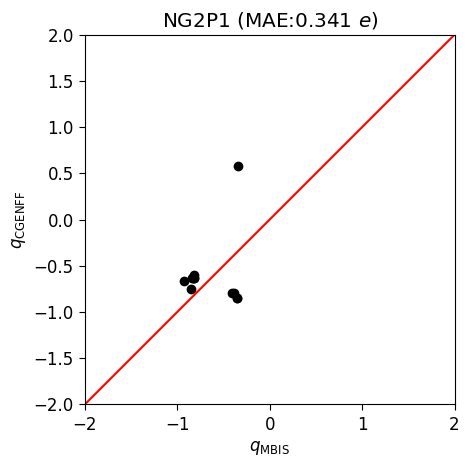

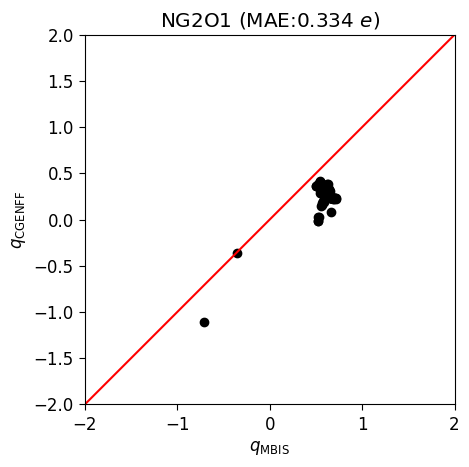

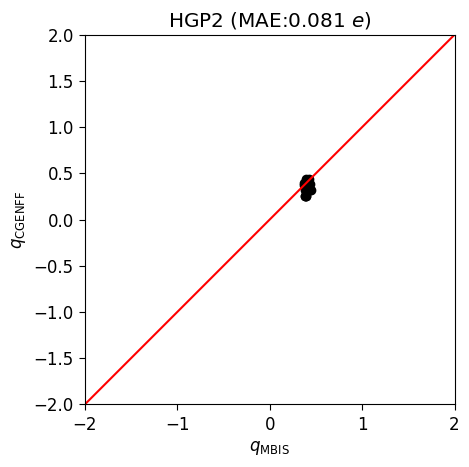

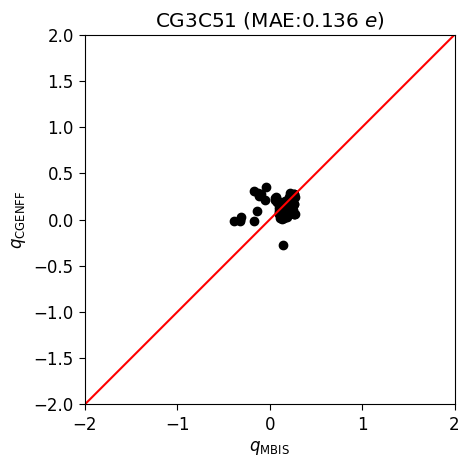

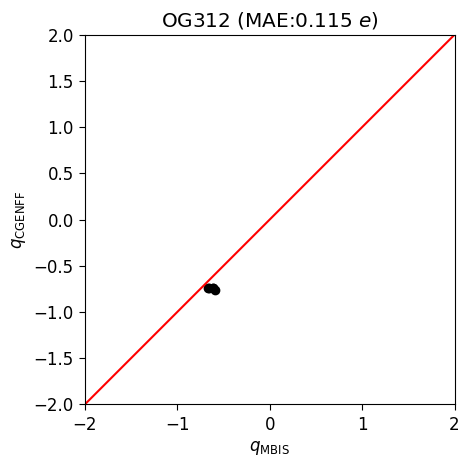

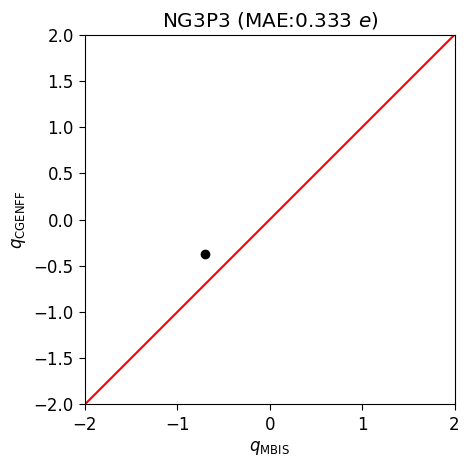

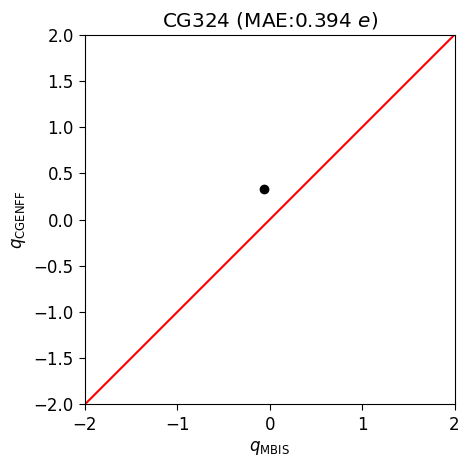

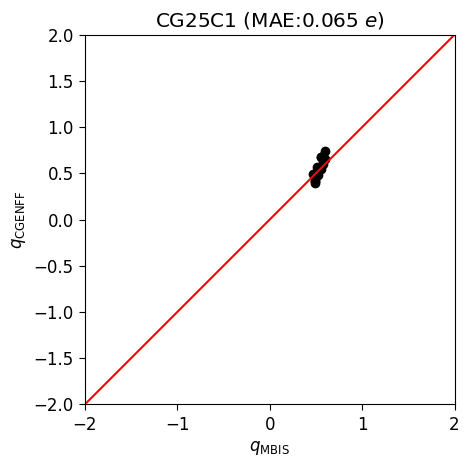

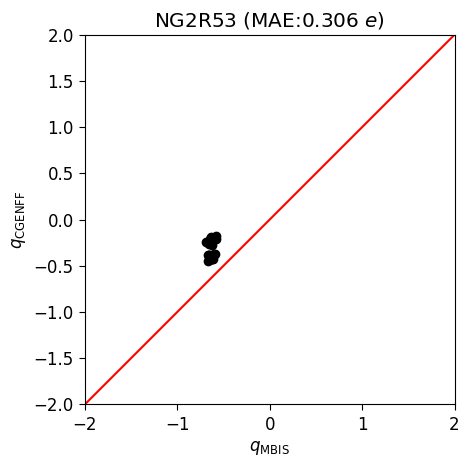

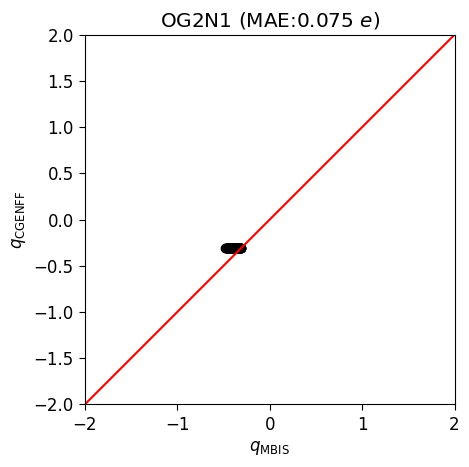

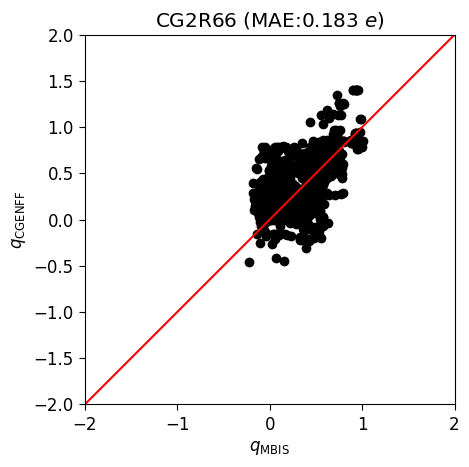

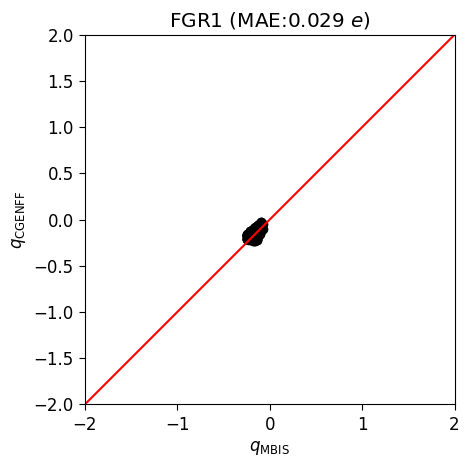

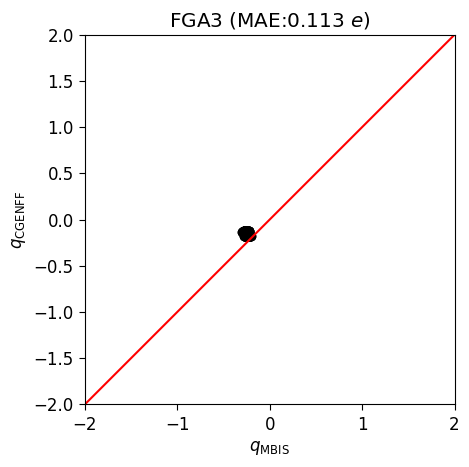

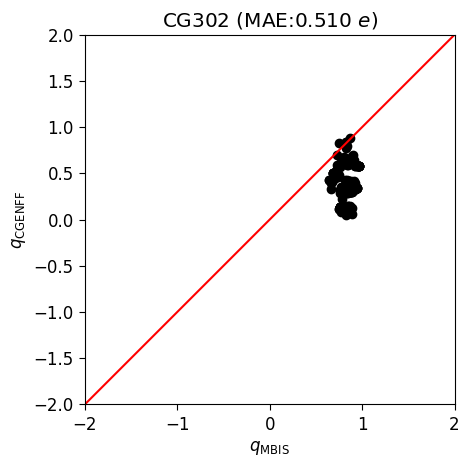

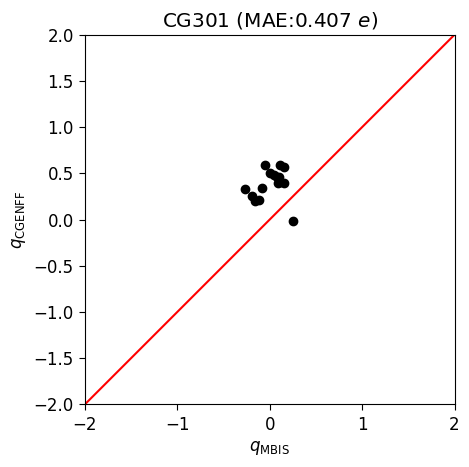

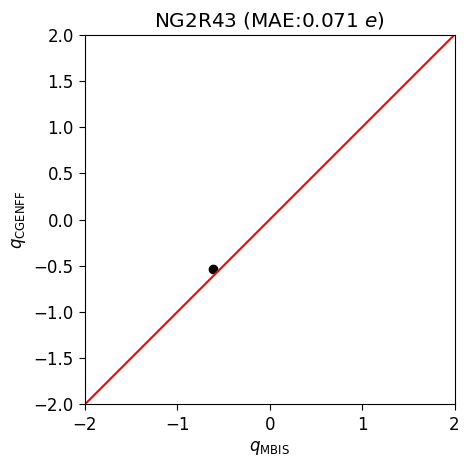

In [77]:
for at in charge_comparison["atom_id"].unique():
    _ = charge_comparison[charge_comparison["atom_id"] == at]
    plt.scatter(_["mbis_q"], _["cgenff_q"], alpha=1, color="k")
    plt.plot([-2,2], [-2,2], c="r")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xlabel(r"$q_{\mathrm{MBIS}}$")
    plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
    plt.gca().set_aspect("equal")
    MAE =np.mean(abs( _["mbis_q"] - _["cgenff_q"]))
    title = f"{at} (MAE:{MAE:.3f} $e$)"
    plt.title(title)
    plt.show()

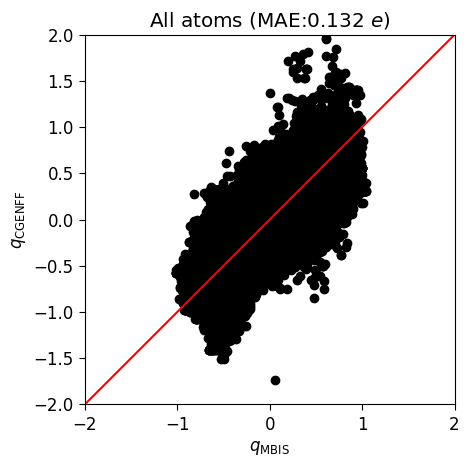

In [65]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"], alpha=1, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]))
title = f"All atoms (MAE:{MAE:.3f} $e$)"
plt.title(title)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [66]:
# "_".join([str(_) for _ in [Path("/test"), Path("/test")]])

In [67]:
import optax
np.mean(optax.l2_loss(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]))

np.float64(0.01917653035209648)

In [68]:
np.mean(optax.l2_loss(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]*0))

np.float64(0.06907889989155569)

In [69]:
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]))

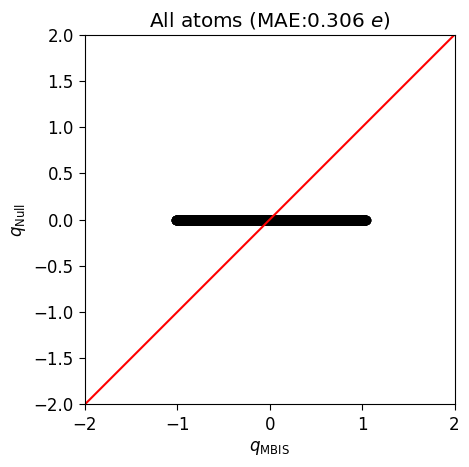

In [70]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"]*0, alpha=1, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
MAE =np.mean(abs( charge_comparison["mbis_q"] - charge_comparison["cgenff_q"]*0))
title = f"All atoms (MAE:{MAE:.3f} $e$)"
plt.title(title)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{Null}}$")
plt.gca().set_aspect("equal")

In [133]:
plt.scatter(charge_comparison["mbis_q"], charge_comparison["cgenff_q"], alpha=0.01, color="k")
plt.plot([-2,2], [-2,2], c="r")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [134]:
batch["mono"][nonzero]

array([-0.47088664, -0.10475539,  0.0377145 , -0.02745989, -0.34160904,
        0.56882062, -0.7696491 , -0.30255123, -0.04012136,  0.15759753,
        0.14847546,  0.16479985,  0.12106948,  0.14825589,  0.15621546,
        0.20332931,  0.35078937])

In [142]:
np.sum(cgenff_charges), np.sum(batch["mono"][nonzero])

(np.float64(5.551115123125783e-17), np.float64(3.4817794384023326e-05))

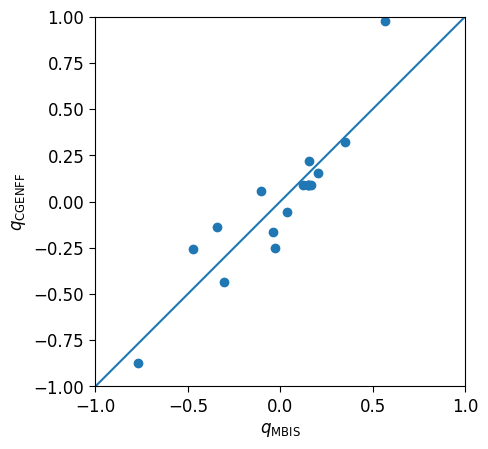

In [158]:
plt.scatter(batch["mono"][nonzero], cgenff_charges)
plt.plot([-1,1], [-1,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r"$q_{\mathrm{MBIS}}$")
plt.ylabel(r"$q_{\mathrm{CGENFF}}$")
plt.gca().set_aspect("equal")

In [175]:
df = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9.csv")
df

Unnamed: 0.1  Unnamed: 0  \
0                  0           0   
1                  1           1   
2                  2           2   
3                  3           3   
4                  4           4   
...              ...         ...   
133880        133880      133880   
133881        133881      133881   
133882        133882      133882   
133883        133883      133883   
133884        133884      133884   

                                                    inchi  \
0                                       InChI=1S/CH4/h1H4   
1                                       InChI=1S/H3N/h1H3   
2                                       InChI=1S/H2O/h1H2   
3                                InChI=1S/C2H2/c1-2/h1-2H   
4                                   InChI=1S/CHN/c1-2/h1H   
...                                                   ...   
133880  InChI=1S/C7H7NO/c1-2-4-3-5-6(8(2)4)7(1,3)9-5/h...   
133881  InChI=1S/C7H7NO/c1-7-2-4-5(8(1)4)3(7)6(2)9-7/h...   
133882  InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...   
133883  InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...   
133884  InChI=1S/C7H7NO/c1-7-5-2-3(4(2)9-7)6(7)8(1)5/h...   

                     smiles  rotational_constant_a  rotational_constant_b  \
0                         C              157.71180             157.709970   
1                         N              293.60975             293.541110   
2                         O              799.58812             437.903860   
3                       C#C                0.00000              35.610036   
4                       C#N                0.00000              44.593883   
...                     ...                    ...                    ...   
133880  C1C2C3C4C5OC14C5N23                3.59483               2.198990   
133881  C1N2C3C2C2C4OC12C34                3.65648               2.142370   
133882  C1N2C3C4C5C2C13CN45                3.67118               2.143140   
133883  C1N2C3C4C5CC13C2C45                3.52845               2.151310   
133884  C1N2C3C4C5OC13C2C45                3.64015               2.217640   

        rotational_constant_c  dipole_moment  polarizability    homo    lumo  \
0                  157.706990         0.0000           13.21 -0.3877  0.1171   
1                  191.393970         1.6256            9.46 -0.2570  0.0829   
2                  282.945450         1.8511            6.31 -0.2928  0.0687   
3                   35.610036         0.0000           16.28 -0.2845  0.0506   
4                   44.593883         2.8937           12.99 -0.3604  0.0191   
...                       ...            ...             ...     ...     ...   
133880               1.904230         1.6637           69.37 -0.2254  0.0588   
133881               1.904390         1.2976           69.52 -0.2393  0.0608   
133882               1.895010         1.2480           73.60 -0.2233  0.0720   
133883               1.865820         1.9576           77.40 -0.2122  0.0881   
133884               1.937930         0.8626           69.48 -0.2316  0.0742   

           gap        r2  zero_point_energy          u0        u298  \
0       0.5048   35.3641           0.044749  -40.478930  -40.476062   
1       0.3399   26.1563           0.034358  -56.525887  -56.523026   
2       0.3615   19.0002           0.021375  -76.404702  -76.401867   
3       0.3351   59.5248           0.026841  -77.308427  -77.305527   
4       0.3796   48.7476           0.016601  -93.411888  -93.409370   
...        ...       ...                ...         ...         ...   
133880  0.2842  760.7472           0.127406 -400.633868 -400.628599   
133881  0.3002  762.6354           0.127495 -400.629713 -400.624444   
133882  0.2953  780.3553           0.140458 -380.753918 -380.748619   
133883  0.3003  803.1904           0.152222 -364.720374 -364.714974   
133884  0.3058  756.3557           0.127862 -400.633052 -400.627892   

              h298        g298  heat_capacity  
0       -40.475117  -40.498597          6.469  
1      

In [176]:
pd.DataFrame(gdb_fails).to_csv("qm9-fails.csv", index=False)

In [177]:
fails = []
for i in range(len(gdb_fails)):
    fails.append(Chem.MolFromSmiles(gdb_fails[i][1]))
    fails.append(Chem.MolFromSmiles(gdb_fails[i][2]))


In [178]:
len(fails) // 2

1711

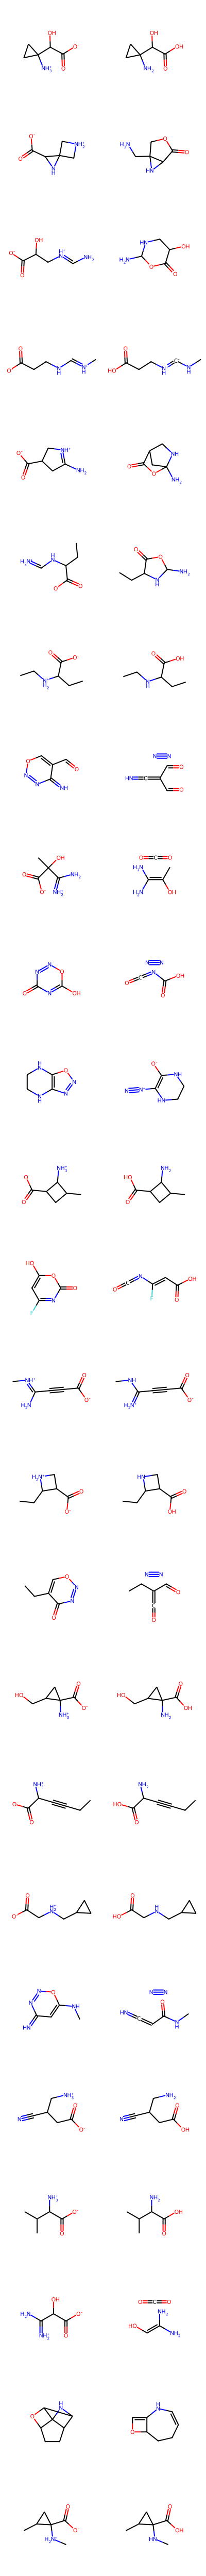

In [182]:
Draw.MolsToGridImage(fails[400:], molsPerRow=2)

In [7]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.patches as mpatches


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}


In [8]:
colors = {"dcm-1": "y", "dcm-2": "r", "dcm-3": "g", "dcm-4": "b", }

In [9]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [6]:
def plot_validation(run, data_label = "Loss/valid"):
    files = {_.parents[0].name: _ for _ in list(ddir.glob(f"{run}/*/best*"))}
    KEYS = list(files.keys())
    # for i, _ in enumerate(KEYS):
    #     print(i, _)
    fig, ax = plt.subplots()
    for i, k in enumerate(KEYS[:]):
        file = files[KEYS[i]].parents[0]
        try:
            _ = parse_tensorboard(str(file), 
                              [data_label])
            dcm = "dcm-"+k.split("-")[2]
            # print(_[data_label])
            _[data_label].plot("step", "value", ax=ax, 
                                 color=colors[dcm],
                                  alpha=0.6)
        except:
            pass
    # plt
    dc1_patch = mpatches.Patch(color='y', label='dcm-1')
    dc2_patch = mpatches.Patch(color='r', label='dcm-2')
    dc3_patch = mpatches.Patch(color='g', label='dcm-3')
    dc4_patch = mpatches.Patch(color='b', label='dcm-4')
    ax.legend(handles=[dc1_patch, dc2_patch, dc3_patch, dc4_patch], 
              loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0.0001, 0.1)
    ax.set_yscale("log")
    # ax.set_xscale("log")
    plt.ylabel("Validation loss", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)

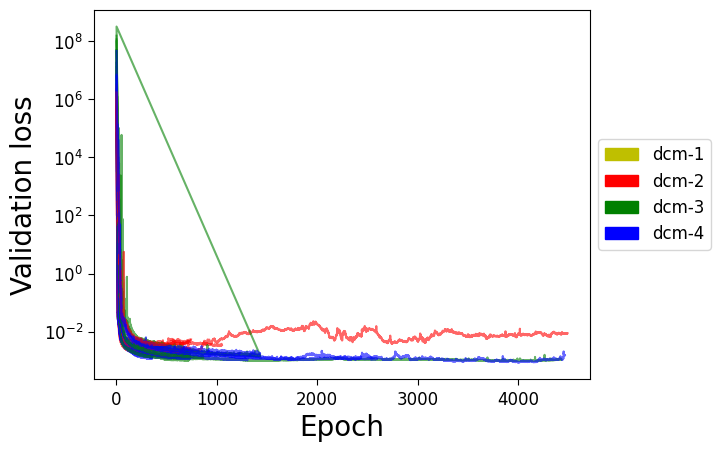

In [229]:
plot_validation("runs2")

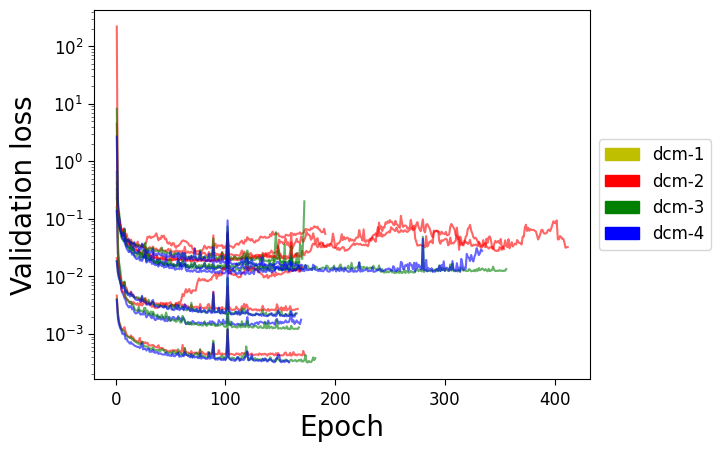

In [230]:
plot_validation("runs4")

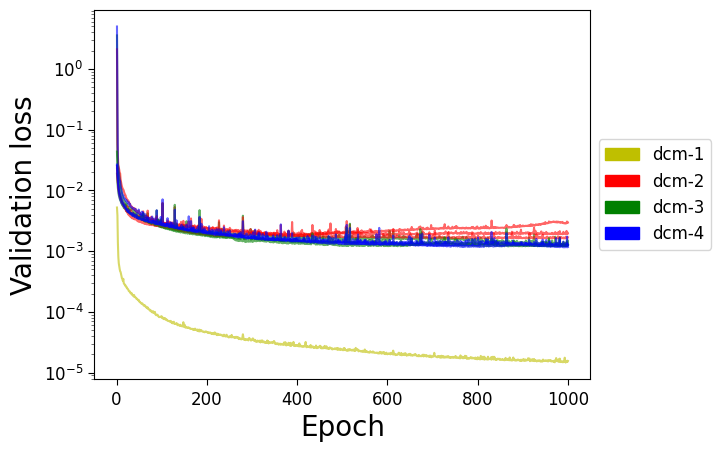

In [231]:
plot_validation("runs5")

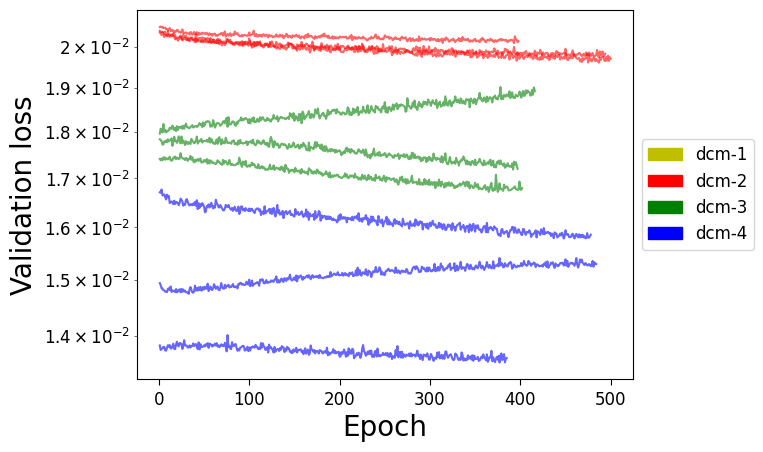

In [232]:
plot_validation("runs888")

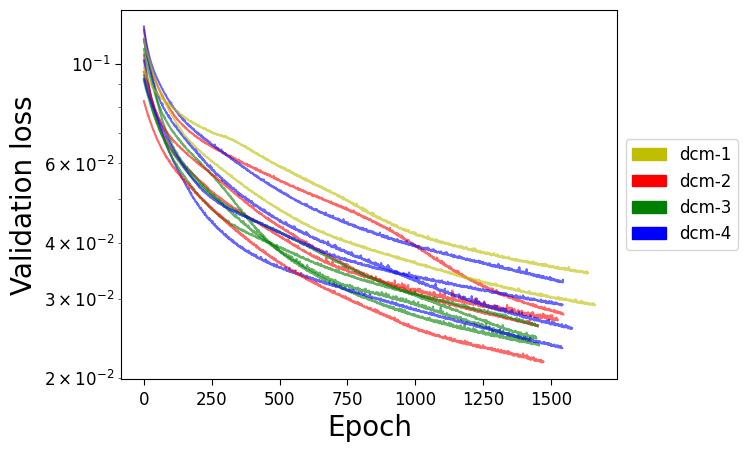

In [233]:
plot_validation("test2")

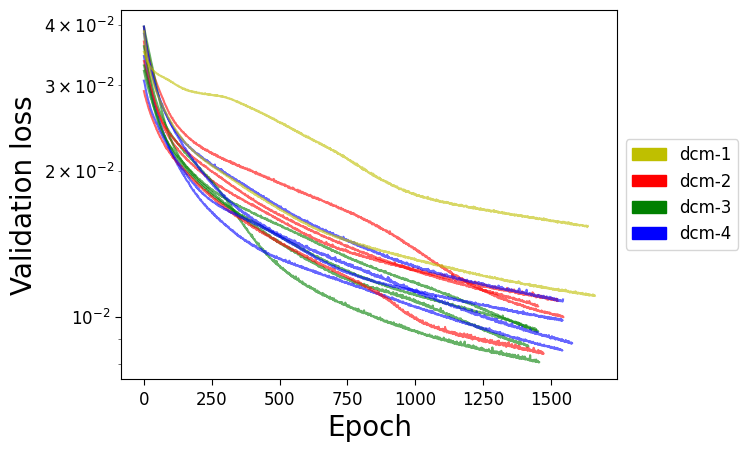

In [35]:
plot_validation("test2", "esp_l/valid")
# plt.xlim(1500, 1550)
# plt.ylim(1.*10**-2, 1.5*10**-2)

In [251]:
# plot_validation("test2", "mono_l/valid")

(0.013999999999999999, 0.027999999999999997)

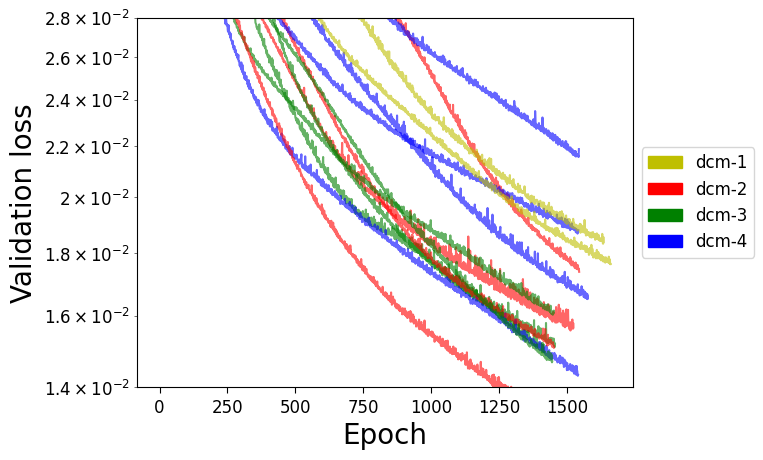

In [390]:
plot_validation("test2", "dipo_l/valid")
# plt.xlim(1500, 1550)
plt.ylim(1.4*10**-2, 2.8*10**-2)

In [438]:
# from dcmnet.training_dipole import 

In [439]:
decay_rate = (1e-6 / 0.001) ** (1 / 5000)

In [496]:
lr_schedule = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10,
    decay_rate=decay_rate,
    end_value=1e-6,  # Set the final value to explicitly stop at final_lr
    staircase=False  # Smooth decay, set True if you want step-wise decay
)

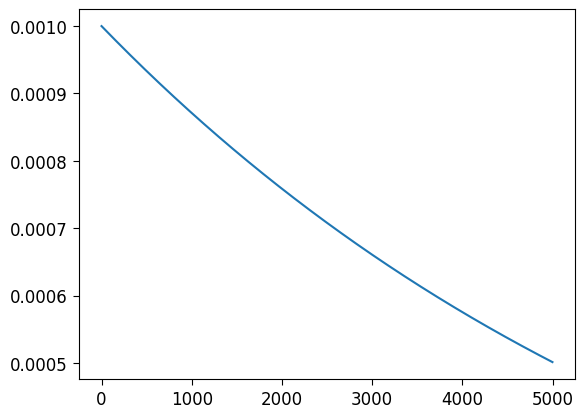

In [497]:
plt.plot([lr_schedule(i) for i in range(5000)])
# plt.xlim(0,150)
# plt.yscale("log")

0.0


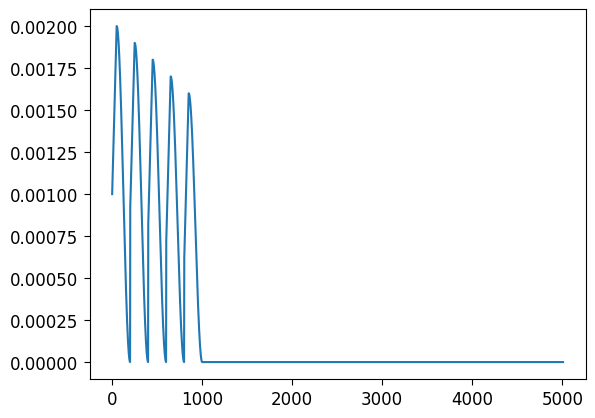

In [3]:
lr_schedule = optax.sgdr_schedule([{"init_value": 0.001 - i*0.0001, 
                                    "peak_value": 0.002 - i*0.0001,
                                    "warmup_steps": 50,
                                    "decay_steps": 200 } for i in range(5)])

rates = [lr_schedule(i) for i in range(5010)]
print(rates[-1])
plt.plot(rates)
# plt.xlim(0,1000)

(array([1037.,  459.,  379.,  367.,  374.,  399.,  443.,  620.,  583.,
         349.]),
 array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
        0.0016, 0.0018, 0.002 ]),
 <BarContainer object of 10 artists>)

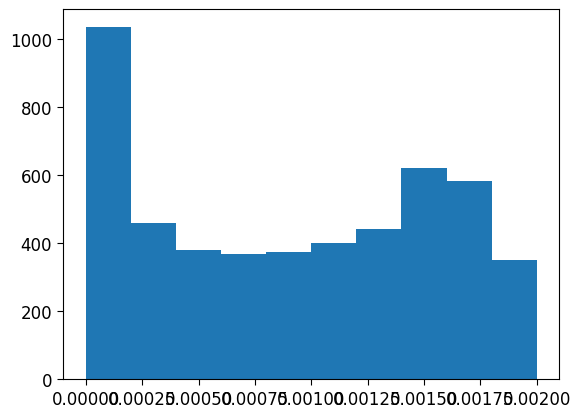

In [560]:
plt.hist(rates)

0.00025


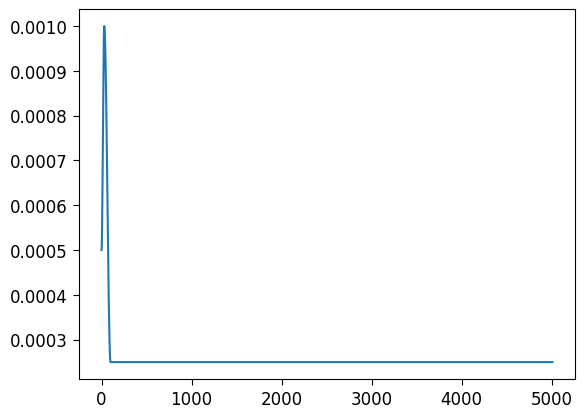

In [31]:
lr_schedule = optax.cosine_onecycle_schedule(
    # init_value=0.001,
    peak_value=0.001,
    transition_steps=100,
    div_factor=2,
    final_div_factor=2
    # decay_steps = 5000,
)
rates = [lr_schedule(i) for i in range(5010)]
print(rates[-1])
plt.plot(rates)
# plt.xlim(0,100)
# plt.yscale("log")

In [3]:
num_cycles = 10
lr_schedule = optax.join_schedules(schedules=
                                    [optax.cosine_onecycle_schedule(
    peak_value=0.0005 - 0.00005*i,
    transition_steps=500,
    div_factor=1.1,
    final_div_factor=2
) for i in range(num_cycles)], 
                                   boundaries=jnp.cumsum(jnp.array([500] * num_cycles)))

rates = [lr_schedule(i) for i in range(5010)]
print(rates[-1])


2.2727272e-05


(0.0, 2000.0)

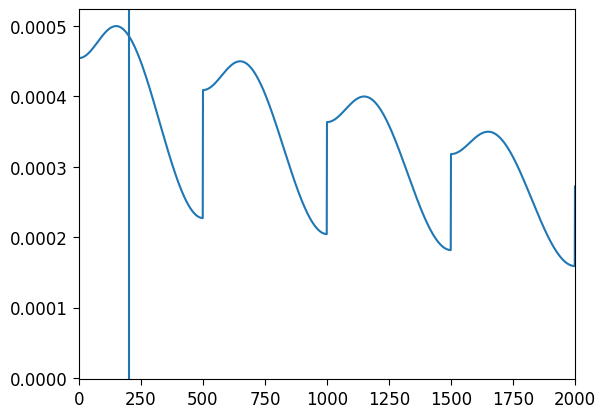

In [4]:
plt.plot(rates)
plt.axvline(200)
plt.xlim(0,2000)
# plt.yscale("log")

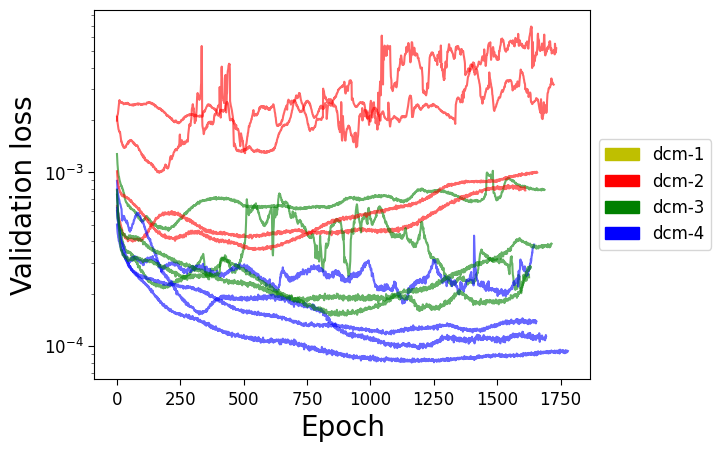

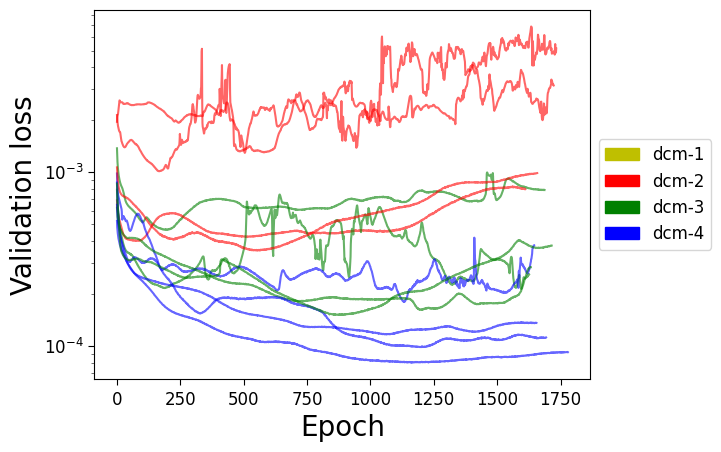

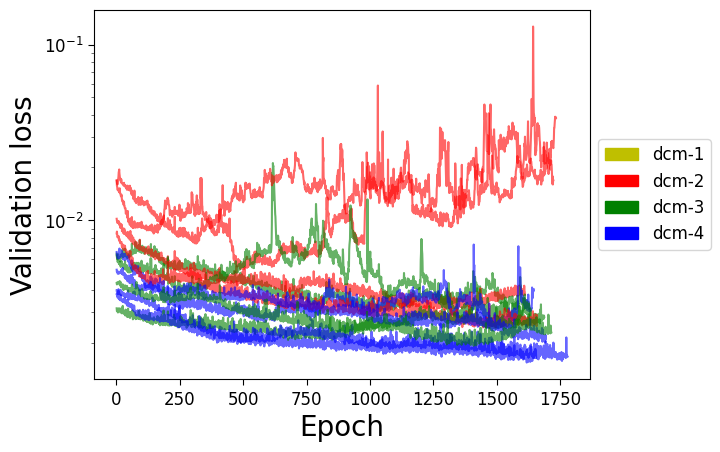

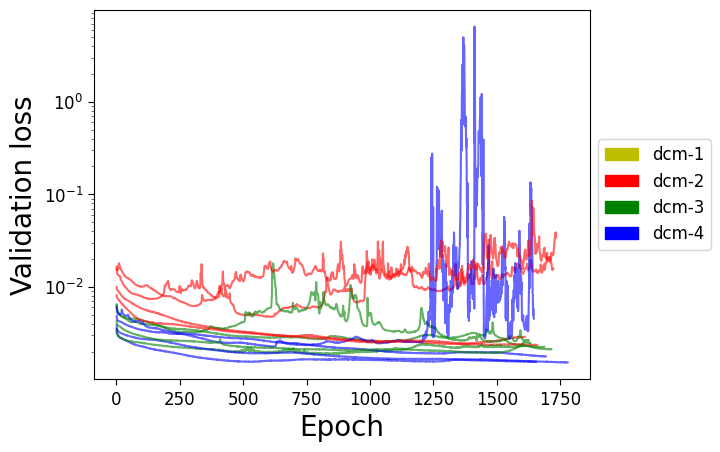

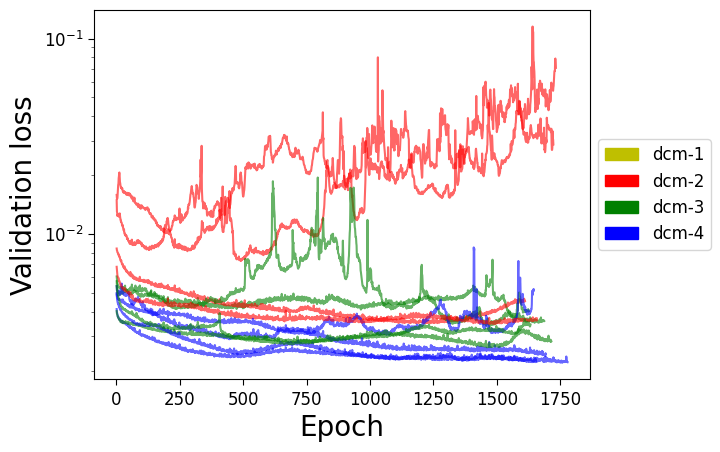

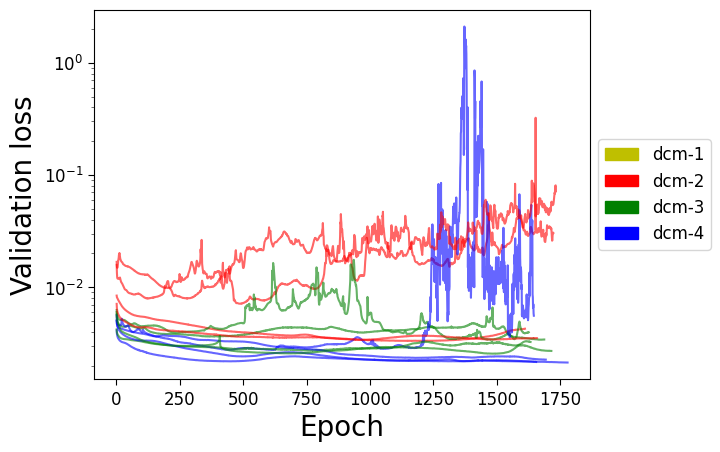

In [10]:
plot_validation("test4", "mono_l/valid")
plot_validation("test4", "mono_l/train")
plot_validation("test4", "dipo_l/valid")
plot_validation("test4", "dipo_l/train")
plot_validation("test4", "esp_l/valid")
plot_validation("test4", "esp_l/train")



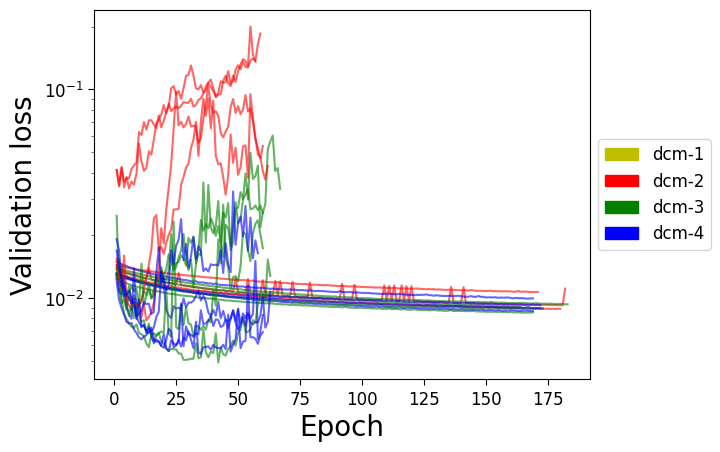

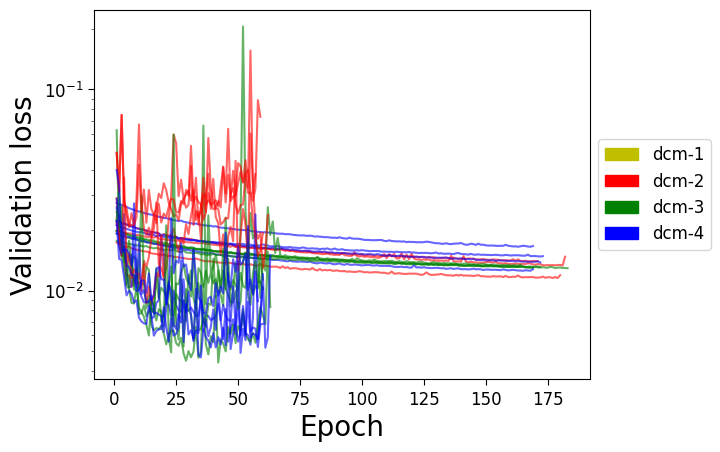

In [11]:
plot_validation("test3", "esp_l/valid")
print()
plot_validation("test3", "dipo_l/valid")
print()
# plot_validation("test3", "mono_l/valid")

In [320]:
from dcmnet.analysis import create_model_and_params

In [85]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")
p = ddir / "test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-200343dcm-4-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"
p = ddir / "test2/20240926-195425dcm-3-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"

# name1/

#

In [25]:
model, params = create_model_and_params(p, debug=True)


{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 3.0, 'include_pseudotensors': True, 'debug': True}


In [26]:
model

MessagePassingModelDEBUG(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
    include_pseudotensors = True
)

In [27]:
params["params"]["TensorDense_0"]["dense"]["1-"]["kernel"].shape

(16, 6)

In [28]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
                Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-40000-0.npz"#"data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [29]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [30]:
batch = valid_batches[0]

In [31]:
rotated_batch = batch.copy()

In [32]:
import e3x
R = e3x.so3.random_rotation(data_key)

In [33]:
idxs = []
for _ in np.nonzero(batch["Z"])[0]:
    for i in range(4):
        idxs.append(_*4+i)
idxs = np.array(idxs)

In [34]:
rotated_batch["vdw_surface"].shape

(1, 3200, 3)

In [35]:
rotated_batch["R"] = rotated_batch["R"]@R
rotated_batch["vdw_surface"] = rotated_batch["vdw_surface"]@R

In [36]:
rotated_batch["vdw_surface"].shape

(1, 3200, 3)

In [37]:
mono, dipo = apply_model(model, params, batch, 1)

# error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
#                                   1, model.n_dcm,
#                                        plot=True,
#                                        id=True,
#                               )

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [38]:
np.linalg.norm(dipo[idxs], axis=-1)

array([0.03995881, 0.10634533, 0.03978472, 0.00616987, 0.03062055,
       0.05337867, 0.04492039, 0.01497616, 0.04344733, 0.04453675,
       0.00699067, 0.06575396, 0.00506741, 0.01556755, 0.04078629,
       0.00647742, 0.02006987, 0.04589762, 0.06410828, 0.00860288,
       0.06605298, 0.01414999, 0.01192929, 0.05851729, 0.05595624,
       0.00548513, 0.07159785, 0.00513485, 0.02364565, 0.02981395,
       0.01676863, 0.06389601, 0.06111143, 0.02610966, 0.00222256,
       0.00603913, 0.01404219, 0.04858905, 0.04303575, 0.00557803,
       0.04516298, 0.03242366, 0.00557803, 0.04516298, 0.03242366,
       0.00557803, 0.04516298, 0.03242366, 0.00557803, 0.04516298,
       0.03242366, 0.00557803], dtype=float32)

In [39]:
mono, dipo = apply_model(model, params, rotated_batch, 1)

# error, esp, keys, _ = evaluate_dc(rotated_batch, dipo, mono, 
#                                   1, model.n_dcm,
#                                        plot=True,
#                                        id=True,
#                               )

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [40]:
np.linalg.norm(dipo[idxs], axis=-1)

array([0.03995879, 0.10634539, 0.03978472, 0.00616989, 0.03062049,
       0.05337872, 0.04492035, 0.01497621, 0.04344734, 0.04453674,
       0.00699066, 0.06575391, 0.00506741, 0.01556754, 0.04078615,
       0.00647742, 0.02006992, 0.0458976 , 0.06410825, 0.00860285,
       0.06605277, 0.01415   , 0.01192928, 0.0585173 , 0.05595611,
       0.00548512, 0.07159777, 0.00513486, 0.02364567, 0.02981398,
       0.01676865, 0.06389603, 0.06111143, 0.02610967, 0.00222256,
       0.00603914, 0.01404219, 0.04858906, 0.04303575, 0.00557803,
       0.04516306, 0.03242369, 0.00557803, 0.04516306, 0.03242369,
       0.00557803, 0.04516306, 0.03242369, 0.00557803, 0.04516306,
       0.03242369, 0.00557803], dtype=float32)

In [41]:
m,d = model.apply(params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,)

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [42]:
d.shape

(60, 3, 3)

In [117]:
# 

from dcmnet.analysis import *
from tqdm import tqdm

In [119]:
path = Path("/pchem-data/meuwly/boittier/home/spice")
paths = list(path.glob("*"))
# paths

In [120]:
outputs = []

for path in tqdm(paths):
    outputs.append(multipoles(path))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [02:11<00:00,  2.09s/it]


In [137]:
rmse_mono_masked = [_["rmse_mono_masked"] for _ in outputs]
rmse_dipo_masked = [_["rmse_dipo_masked"] for _ in outputs]
rmse_quad_masked = [_["rmse_quad_masked"] for _ in outputs]

D_mae_mono = [_["D_mae_mono"] for _ in outputs]
D_mae_dipo = [_["D_mae_dipo"] for _ in outputs]

In [144]:
np.mean(rmse_mono_masked) 

np.float32(0.8496295)

In [139]:
np.mean(rmse_dipo_masked)

np.float32(0.4012953)

In [140]:
np.mean(rmse_quad_masked)

np.float32(0.32082984)

In [145]:
np.mean(D_mae_mono)

np.float32(0.2551952)

In [142]:
np.mean(D_mae_dipo)

np.float32(0.0015402243)